# 📊 Análisis Comparativo: Growth Stocks vs Value Stocks
## Disclaimer: esto no representa ninguna recomendación de inversión. Fines educativos únicamente.
---

## 🎯 El Problema

Los inversores enfrentan un dilema constante: **¿invertir en empresas de alto crecimiento o en empresas establecidas de valor?** Las metodologías tradicionales de valoración presentan dos limitaciones críticas:

### 1. Análisis Estático vs Realidad Dinámica

Las métricas convencionales (P/E ratio, FCF Yield, ROIC) ofrecen una **fotografía estática** del presente, ignorando la incertidumbre inherente del futuro. Un P/E de 25x puede indicar sobrevaloración o anticipar crecimiento extraordinario, pero no cuantifica la probabilidad de cada escenario.

### 2. Incertidumbre No Modelada

El crecimiento futuro del FCF, los múltiplos de salida y las tasas de descuento no son valores determinísticos. Cada variable tiene una **distribución de probabilidad** que el análisis tradicional ignora, llevando a decisiones basadas en promedios que ocultan riesgos y oportunidades.

### 3. Falsa Precisión

Calcular que una acción vale exactamente $127.45 transmite certeza donde no existe. La valoración correcta es un **rango probabilístico**: "80% de probabilidad de valer entre $95-$160, con mediana en $118".

---

## 💡 Nuestra Solución: Análisis Dual

Este notebook implementa un **framework cuantitativo híbrido** que combina:

### A) Análisis Fundamental Tradicional

Calculamos métricas core para establecer una línea base:

$$\text{FCF Yield} = \frac{\text{FCF}_{TTM}}{\text{Market Cap}} \times 100$$

$$\text{ROIC} = \frac{\text{NOPAT}}{\text{Invested Capital}} \times 100$$

Donde $\text{NOPAT} = \text{Operating Income} \times (1 - \text{Tax Rate})$ y $\text{Invested Capital} = \text{Total Assets} - \text{Current Liabilities} - \text{Cash}$

### B) Valoración Estocástica con Monte Carlo

Modelamos la incertidumbre mediante distribuciones probabilísticas:

- **Crecimiento FCF**: $g \sim \mathcal{N}(\mu_g, \sigma_g^2)$ donde $\mu_g$ = crecimiento histórico, $\sigma_g = 0.15$

- **FCF Yield de salida**: $y \sim \text{LogNormal}(\mu_y, \sigma_y^2)$ acotado en $[0.01, 0.15]$

- **Tasa de descuento**: $r \sim \mathcal{N}(0.10, 0.02^2)$ acotado en $[0.05, 0.20]$

Para cada simulación $i$:

$$\text{FCF}_{t+1}^{(i)} = \text{FCF}_t \times (1 + g^{(i)})$$

$$\text{Valor Terminal}^{(i)} = \frac{\text{FCF}_{t+1}^{(i)}}{y^{(i)}}$$

$$\text{Valor Presente}^{(i)} = \frac{\text{Valor Terminal}^{(i)}}{1 + r^{(i)}}$$

Ejecutamos **N = 10,000** simulaciones para obtener la distribución completa de precios posibles.

---

## 📊 Output del Análisis

**Métricas estáticas**: Rankings de FCF Yield, ROIC, P/E Ratio por categoría (Growth vs Value)

**Métricas estocásticas**: Distribuciones de precio, probabilidades de sub/sobrevaloración, intervalos de confianza P10-P90, upside potential mediano

**Matriz Riesgo-Retorno**: Scatter plot que posiciona cada acción según volatilidad implícita (riesgo) vs upside esperado (retorno)

**Persistencia**: Base de datos SQLite para tracking histórico y análisis de tendencias

---

## 🎯 Decisión Informada

En lugar de preguntarnos "¿cuánto vale?", respondemos "¿qué distribución de valores es más probable y qué riesgo asumimos?". 

Esto transforma la inversión de una apuesta binaria a una **gestión cuantitativa de probabilidades**.

**Stocks analizadas:**
- **Growth**: SPOT (Spotify), DUOL (Duolingo), UBER (Uber), COIN (Coinbase)
- **Value**: KO (Coca-Cola), PG (Procter & Gamble), JNJ (Johnson & Johnson), WMT (Walmart)

---

## 1. Setup y Dependencias

In [45]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import sqlite3
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
%matplotlib inline

## 2. Clase StockAnalyzer

In [46]:
class StockAnalyzer:
    def __init__(self, ticker):
        self.ticker = ticker
        self.stock = yf.Ticker(ticker)
        self.info = self.stock.info
        
    def get_quarterly_financials(self):
        qtr_cf = self.stock.quarterly_cashflow
        qtr_income = self.stock.quarterly_income_stmt
        qtr_balance = self.stock.quarterly_balance_sheet
        
        if not qtr_cf.empty:
            qtr_cf.columns = pd.to_datetime(qtr_cf.columns)
        if not qtr_income.empty:
            qtr_income.columns = pd.to_datetime(qtr_income.columns)
        if not qtr_balance.empty:
            qtr_balance.columns = pd.to_datetime(qtr_balance.columns)
            
        return qtr_cf, qtr_income, qtr_balance
    
    def calculate_fcf(self, qtr_cf):
        fcf_data = []
        for date in qtr_cf.columns:
            ocf = qtr_cf.loc['Operating Cash Flow', date] if 'Operating Cash Flow' in qtr_cf.index else 0
            capex = qtr_cf.loc['Capital Expenditure', date] if 'Capital Expenditure' in qtr_cf.index else 0
            fcf = (ocf + capex) / 1e6
            fcf_data.append({'Date': date, 'FCF': fcf})
        return pd.DataFrame(fcf_data).sort_values('Date')
    
    def calculate_roic(self, qtr_income, qtr_balance):
        roic_data = []
        common_dates = sorted(set(qtr_income.columns) & set(qtr_balance.columns))
        
        for date in common_dates[-4:]:
            op_income = qtr_income.loc['Operating Income', date] if 'Operating Income' in qtr_income.index else 0
            tax_rate = 0.21
            nopat = op_income * (1 - tax_rate)
            
            total_assets = qtr_balance.loc['Total Assets', date] if 'Total Assets' in qtr_balance.index else 0
            current_liab = qtr_balance.loc['Current Liabilities', date] if 'Current Liabilities' in qtr_balance.index else 0
            cash = qtr_balance.loc['Cash And Cash Equivalents', date] if 'Cash And Cash Equivalents' in qtr_balance.index else 0
            
            invested_capital = total_assets - current_liab - cash
            
            if invested_capital > 0:
                roic = (nopat / invested_capital) * 100
                roic_data.append({'Date': date, 'ROIC': roic})
        
        return pd.DataFrame(roic_data).sort_values('Date')
    
    def get_summary_metrics(self):
        qtr_cf, qtr_income, qtr_balance = self.get_quarterly_financials()
        fcf_df = self.calculate_fcf(qtr_cf)
        roic_df = self.calculate_roic(qtr_income, qtr_balance)
        
        current_price = self.info.get('currentPrice', np.nan)
        market_cap = self.info.get('marketCap', 0) / 1e9
        pe_ratio = self.info.get('trailingPE', np.nan)
        
        ttm_fcf = fcf_df['FCF'].tail(4).sum() if len(fcf_df) >= 4 else 0
        fcf_yield = (ttm_fcf / (market_cap * 1000)) * 100 if market_cap > 0 else 0
        
        latest_roic = roic_df['ROIC'].iloc[-1] if not roic_df.empty else np.nan
        
        fcf_growth = 0
        if len(fcf_df) >= 4:
            latest_fcf = fcf_df['FCF'].iloc[-1]
            fcf_4q_ago = fcf_df['FCF'].iloc[-4]
            fcf_growth = ((latest_fcf / fcf_4q_ago) - 1) * 100 if fcf_4q_ago != 0 else 0
        
        return {
            'Ticker': self.ticker,
            'Price': current_price,
            'Market Cap ($B)': market_cap,
            'P/E Ratio': pe_ratio,
            'TTM FCF ($M)': ttm_fcf,
            'FCF Yield (%)': fcf_yield,
            'ROIC (%)': latest_roic,
            'FCF Growth YoY (%)': fcf_growth
        }

## 3. Análisis de Value Stocks

In [47]:
value_tickers = ['KO', 'PG', 'JNJ', 'WMT']
value_data = []

print("📊 Analizando Value Stocks...\n")
for ticker in value_tickers:
    try:
        print(f"Procesando {ticker}...")
        analyzer = StockAnalyzer(ticker)
        metrics = analyzer.get_summary_metrics()
        value_data.append(metrics)
    except Exception as e:
        print(f"Error con {ticker}: {e}")

value_df = pd.DataFrame(value_data)
print("\n✅ Value Stocks Analysis Complete")
value_df

📊 Analizando Value Stocks...

Procesando KO...
Procesando PG...
Procesando JNJ...
Procesando WMT...

✅ Value Stocks Analysis Complete


,Ticker,Price,Market Cap ($B),P/E Ratio,TTM FCF ($M),FCF Yield (%),ROIC (%),FCF Growth YoY (%)
0,KO,79.03,340.118798,26.168875,5570.0,1.637663,4.475782,44.980940
1,PG,159.17,372.535067,23.580740,14848.0,3.985665,5.314736,33.696416
2,JNJ,239.99,578.206761,21.738226,18679.0,3.230505,4.531217,65.274907
3,WMT,131.18,1045.878538,45.867130,15263.0,1.459347,3.258474,-70.767319


## 4. Visualización Value Stocks

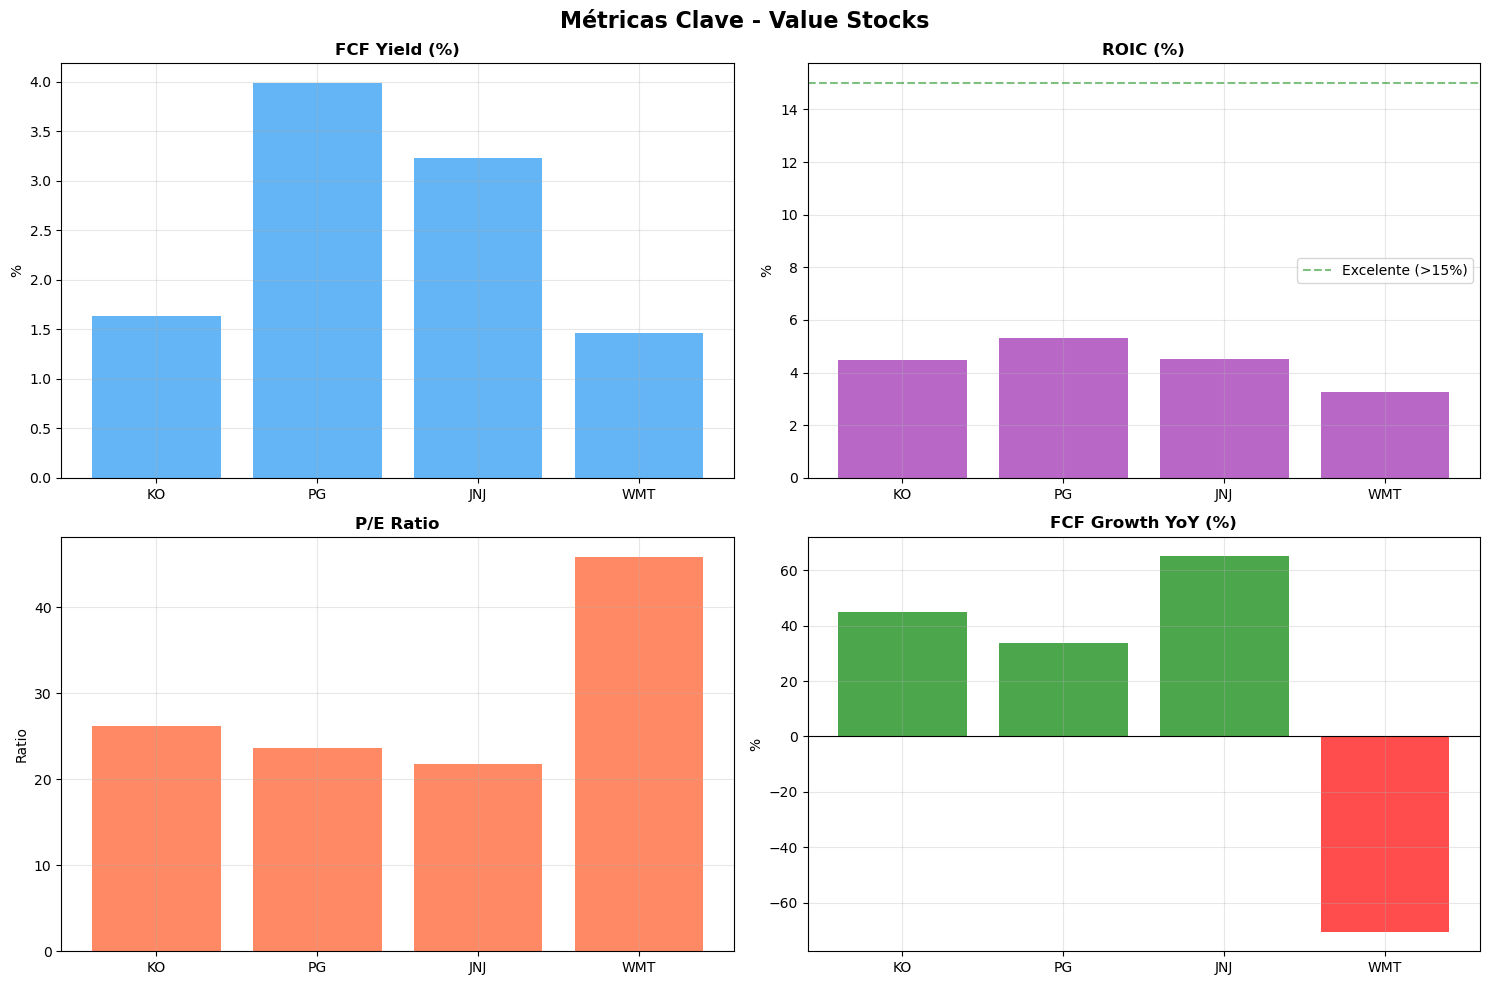

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Métricas Clave - Value Stocks', fontsize=16, fontweight='bold')

# FCF Yield
axes[0, 0].bar(value_df['Ticker'], value_df['FCF Yield (%)'], color='#2196F3', alpha=0.7)
axes[0, 0].set_title('FCF Yield (%)', fontweight='bold')
axes[0, 0].set_ylabel('%')
axes[0, 0].grid(True, alpha=0.3)

# ROIC
axes[0, 1].bar(value_df['Ticker'], value_df['ROIC (%)'], color='#9C27B0', alpha=0.7)
axes[0, 1].set_title('ROIC (%)', fontweight='bold')
axes[0, 1].set_ylabel('%')
axes[0, 1].axhline(y=15, color='green', linestyle='--', alpha=0.5, label='Excelente (>15%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# P/E Ratio
axes[1, 0].bar(value_df['Ticker'], value_df['P/E Ratio'], color='#FF5722', alpha=0.7)
axes[1, 0].set_title('P/E Ratio', fontweight='bold')
axes[1, 0].set_ylabel('Ratio')
axes[1, 0].grid(True, alpha=0.3)

# FCF Growth YoY
colors = ['green' if x > 0 else 'red' for x in value_df['FCF Growth YoY (%)']]
axes[1, 1].bar(value_df['Ticker'], value_df['FCF Growth YoY (%)'], color=colors, alpha=0.7)
axes[1, 1].set_title('FCF Growth YoY (%)', fontweight='bold')
axes[1, 1].set_ylabel('%')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Resumen Value Stocks

In [49]:
print("="*80)
print("📊 RESUMEN EJECUTIVO - VALUE STOCKS")
print("="*80)

print("\n🏆 Mejor FCF Yield:")
best_fcf = value_df.nlargest(1, 'FCF Yield (%)')['Ticker'].values[0]
best_fcf_val = value_df.nlargest(1, 'FCF Yield (%)')['FCF Yield (%)'].values[0]
print(f"   {best_fcf}: {best_fcf_val:.2f}%")

print("\n🏆 Mejor ROIC:")
best_roic = value_df.nlargest(1, 'ROIC (%)')['Ticker'].values[0]
best_roic_val = value_df.nlargest(1, 'ROIC (%)')['ROIC (%)'].values[0]
print(f"   {best_roic}: {best_roic_val:.2f}%")

print("\n🏆 Mayor Crecimiento de FCF:")
best_growth = value_df.nlargest(1, 'FCF Growth YoY (%)')['Ticker'].values[0]
best_growth_val = value_df.nlargest(1, 'FCF Growth YoY (%)')['FCF Growth YoY (%)'].values[0]
print(f"   {best_growth}: {best_growth_val:+.2f}%")

print("\n📈 PROMEDIOS:")
print(f"   FCF Yield promedio: {value_df['FCF Yield (%)'].mean():.2f}%")
print(f"   ROIC promedio: {value_df['ROIC (%)'].mean():.2f}%")
print(f"   P/E promedio: {value_df['P/E Ratio'].mean():.2f}")
print(f"   Crecimiento FCF promedio: {value_df['FCF Growth YoY (%)'].mean():+.2f}%")

print("\n" + "="*80)

📊 RESUMEN EJECUTIVO - VALUE STOCKS

🏆 Mejor FCF Yield:
   PG: 3.99%

🏆 Mejor ROIC:
   PG: 5.31%

🏆 Mayor Crecimiento de FCF:
   JNJ: +65.27%

📈 PROMEDIOS:
   FCF Yield promedio: 2.58%
   ROIC promedio: 4.40%
   P/E promedio: 29.34
   Crecimiento FCF promedio: +18.30%



## 6. Análisis de Growth Stocks

In [50]:
growth_tickers = ['SPOT', 'DUOL', 'UBER', 'COIN']
growth_data = []

print("📈 Analizando Growth Stocks...\n")
for ticker in growth_tickers:
    try:
        print(f"Procesando {ticker}...")
        analyzer = StockAnalyzer(ticker)
        metrics = analyzer.get_summary_metrics()
        growth_data.append(metrics)
    except Exception as e:
        print(f"Error con {ticker}: {e}")

growth_df = pd.DataFrame(growth_data)
print("\n✅ Growth Stocks Analysis Complete")
growth_df

📈 Analizando Growth Stocks...

Procesando SPOT...
Procesando DUOL...
Procesando UBER...
Procesando COIN...

✅ Growth Stocks Analysis Complete


,Ticker,Price,Market Cap ($B),P/E Ratio,TTM FCF ($M),FCF Yield (%),ROIC (%),FCF Growth YoY (%)
0,SPOT,422.61,87.012868,53.494934,2915.000,3.350079,15.356713,-8.095781
1,DUOL,119.40,5.519546,15.037784,347.596,6.297547,7.130069,-4.385444
2,UBER,74.77,155.926741,15.807610,8661.000,5.554532,2.103970,30.715123
3,COIN,165.12,44.525863,14.271392,325.850,0.731822,2.605610,-181.329086


## 7. Visualización Growth Stocks

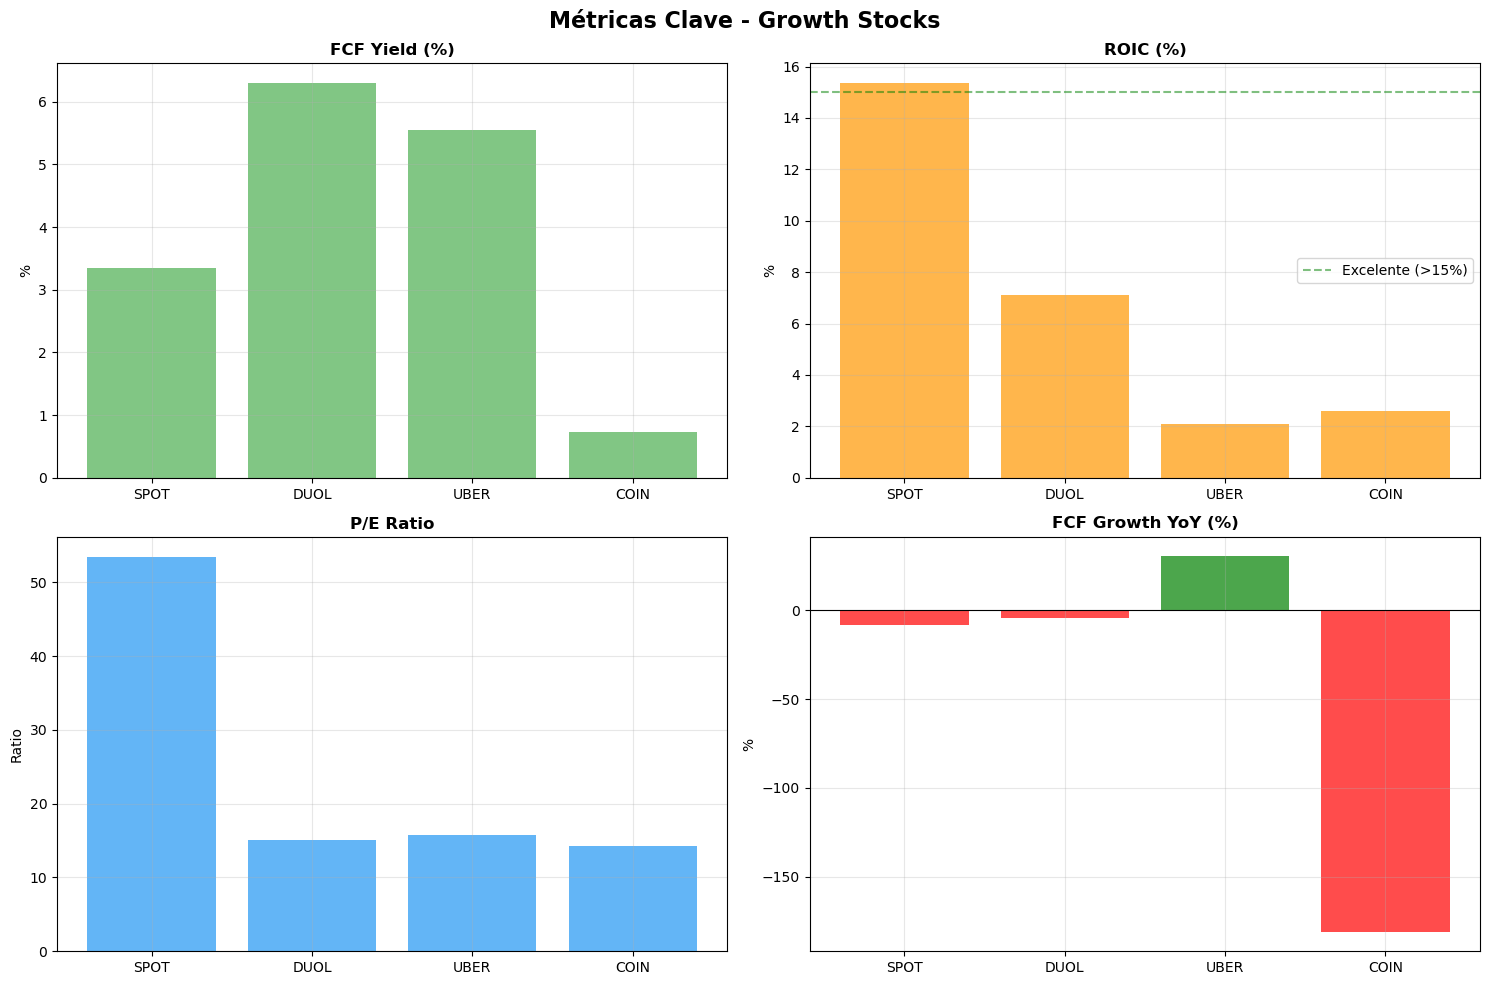

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Métricas Clave - Growth Stocks', fontsize=16, fontweight='bold')

# FCF Yield
axes[0, 0].bar(growth_df['Ticker'], growth_df['FCF Yield (%)'], color='#4CAF50', alpha=0.7)
axes[0, 0].set_title('FCF Yield (%)', fontweight='bold')
axes[0, 0].set_ylabel('%')
axes[0, 0].grid(True, alpha=0.3)

# ROIC
axes[0, 1].bar(growth_df['Ticker'], growth_df['ROIC (%)'], color='#FF9800', alpha=0.7)
axes[0, 1].set_title('ROIC (%)', fontweight='bold')
axes[0, 1].set_ylabel('%')
axes[0, 1].axhline(y=15, color='green', linestyle='--', alpha=0.5, label='Excelente (>15%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# P/E Ratio
axes[1, 0].bar(growth_df['Ticker'], growth_df['P/E Ratio'], color='#2196F3', alpha=0.7)
axes[1, 0].set_title('P/E Ratio', fontweight='bold')
axes[1, 0].set_ylabel('Ratio')
axes[1, 0].grid(True, alpha=0.3)

# FCF Growth YoY
colors = ['green' if x > 0 else 'red' for x in growth_df['FCF Growth YoY (%)']]
axes[1, 1].bar(growth_df['Ticker'], growth_df['FCF Growth YoY (%)'], color=colors, alpha=0.7)
axes[1, 1].set_title('FCF Growth YoY (%)', fontweight='bold')
axes[1, 1].set_ylabel('%')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Resumen Growth Stocks

In [52]:
print("="*80)
print("📊 RESUMEN EJECUTIVO - GROWTH STOCKS")
print("="*80)

print("\n🏆 Mejor FCF Yield:")
best_fcf = growth_df.nlargest(1, 'FCF Yield (%)')['Ticker'].values[0]
best_fcf_val = growth_df.nlargest(1, 'FCF Yield (%)')['FCF Yield (%)'].values[0]
print(f"   {best_fcf}: {best_fcf_val:.2f}%")

print("\n🏆 Mejor ROIC:")
best_roic = growth_df.nlargest(1, 'ROIC (%)')['Ticker'].values[0]
best_roic_val = growth_df.nlargest(1, 'ROIC (%)')['ROIC (%)'].values[0]
print(f"   {best_roic}: {best_roic_val:.2f}%")

print("\n🏆 Mayor Crecimiento de FCF:")
best_growth = growth_df.nlargest(1, 'FCF Growth YoY (%)')['Ticker'].values[0]
best_growth_val = growth_df.nlargest(1, 'FCF Growth YoY (%)')['FCF Growth YoY (%)'].values[0]
print(f"   {best_growth}: {best_growth_val:+.2f}%")

print("\n📈 PROMEDIOS:")
print(f"   FCF Yield promedio: {growth_df['FCF Yield (%)'].mean():.2f}%")
print(f"   ROIC promedio: {growth_df['ROIC (%)'].mean():.2f}%")
print(f"   P/E promedio: {growth_df['P/E Ratio'].mean():.2f}")
print(f"   Crecimiento FCF promedio: {growth_df['FCF Growth YoY (%)'].mean():+.2f}%")

print("\n" + "="*80)

📊 RESUMEN EJECUTIVO - GROWTH STOCKS

🏆 Mejor FCF Yield:
   DUOL: 6.30%

🏆 Mejor ROIC:
   SPOT: 15.36%

🏆 Mayor Crecimiento de FCF:
   UBER: +30.72%

📈 PROMEDIOS:
   FCF Yield promedio: 3.98%
   ROIC promedio: 6.80%
   P/E promedio: 24.65
   Crecimiento FCF promedio: -40.77%



## 9. Tabla Comparativa Completa

In [53]:
combined_df = pd.concat([
    value_df.assign(Category='Value'),
    growth_df.assign(Category='Growth')
], ignore_index=True)

combined_df = combined_df[['Category', 'Ticker', 'Price', 'Market Cap ($B)', 
                           'P/E Ratio', 'TTM FCF ($M)', 'FCF Yield (%)', 
                           'ROIC (%)', 'FCF Growth YoY (%)']]

combined_df.sort_values('FCF Yield (%)', ascending=False)

,Category,Ticker,Price,Market Cap ($B),P/E Ratio,TTM FCF ($M),FCF Yield (%),ROIC (%),FCF Growth YoY (%)
5,Growth,DUOL,119.40,5.519546,15.037784,347.596,6.297547,7.130069,-4.385444
6,Growth,UBER,74.77,155.926741,15.807610,8661.000,5.554532,2.103970,30.715123
1,Value,PG,159.17,372.535067,23.580740,14848.000,3.985665,5.314736,33.696416
4,Growth,SPOT,422.61,87.012868,53.494934,2915.000,3.350079,15.356713,-8.095781
2,Value,JNJ,239.99,578.206761,21.738226,18679.000,3.230505,4.531217,65.274907
0,Value,KO,79.03,340.118798,26.168875,5570.000,1.637663,4.475782,44.980940
3,Value,WMT,131.18,1045.878538,45.867130,15263.000,1.459347,3.258474,-70.767319
7,Growth,COIN,165.12,44.525863,14.271392,325.850,0.731822,2.605610,-181.329086


## 10. Visualización Comparativa: FCF Yield

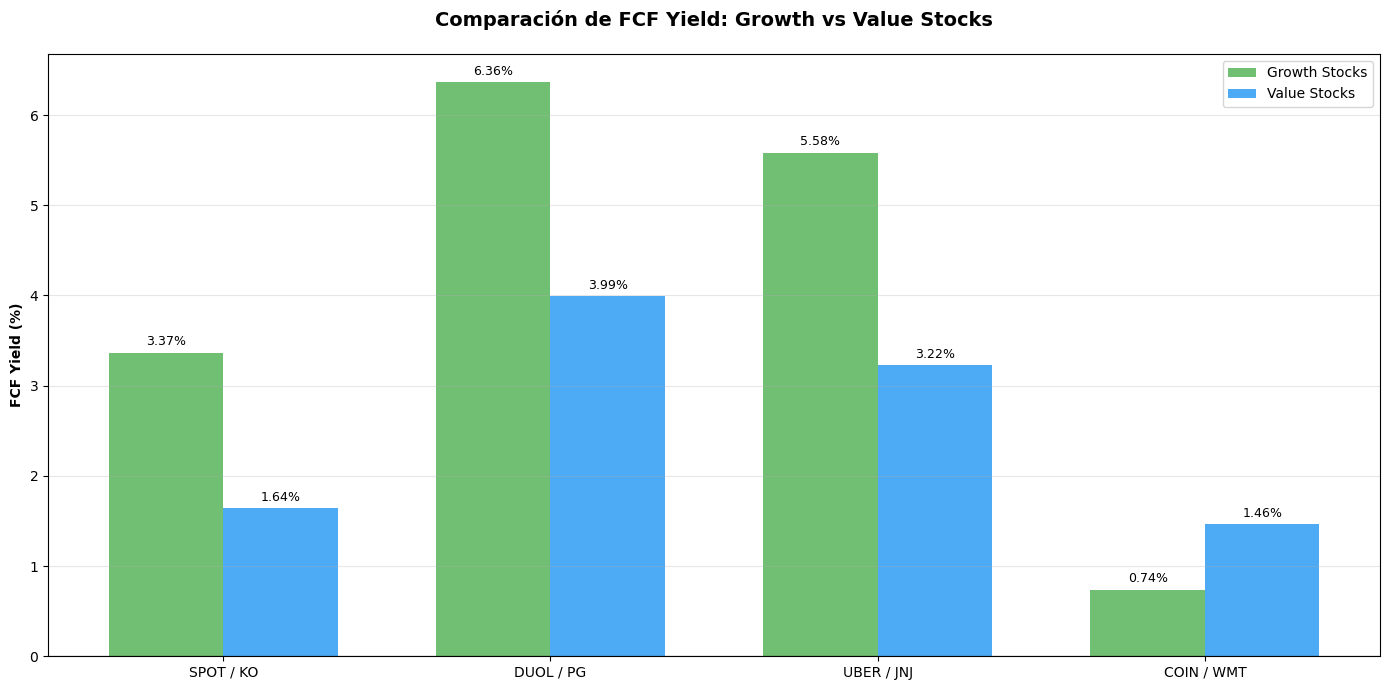

In [54]:
# Creamos las etiquetas combinando los tickers de cada categoría
# Esto asume que el orden en el DF es el correcto para la comparación
labels = [f"{g} / {v}" for g, v in zip(growth_fcf['Ticker'], value_fcf['Ticker'])]

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(growth_fcf))
width = 0.35

# Barras
bars1 = ax.bar(x - width/2, growth_fcf['FCF Yield (%)'], width, 
               label='Growth Stocks', color='#4CAF50', alpha=0.8)
bars2 = ax.bar(x + width/2, value_fcf['FCF Yield (%)'].values, width, 
               label='Value Stocks', color='#2196F3', alpha=0.8)

# Configuración de ejes y títulos
ax.set_ylabel('FCF Yield (%)', fontweight='bold')
ax.set_title('Comparación de FCF Yield: Growth vs Value Stocks', 
             fontsize=14, fontweight='bold', pad=20)

ax.set_xticks(x)
ax.set_xticklabels(labels) # Usamos las etiquetas dinámicas aquí
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Añadir los porcentajes sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{height:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 11. Visualización Comparativa: ROIC

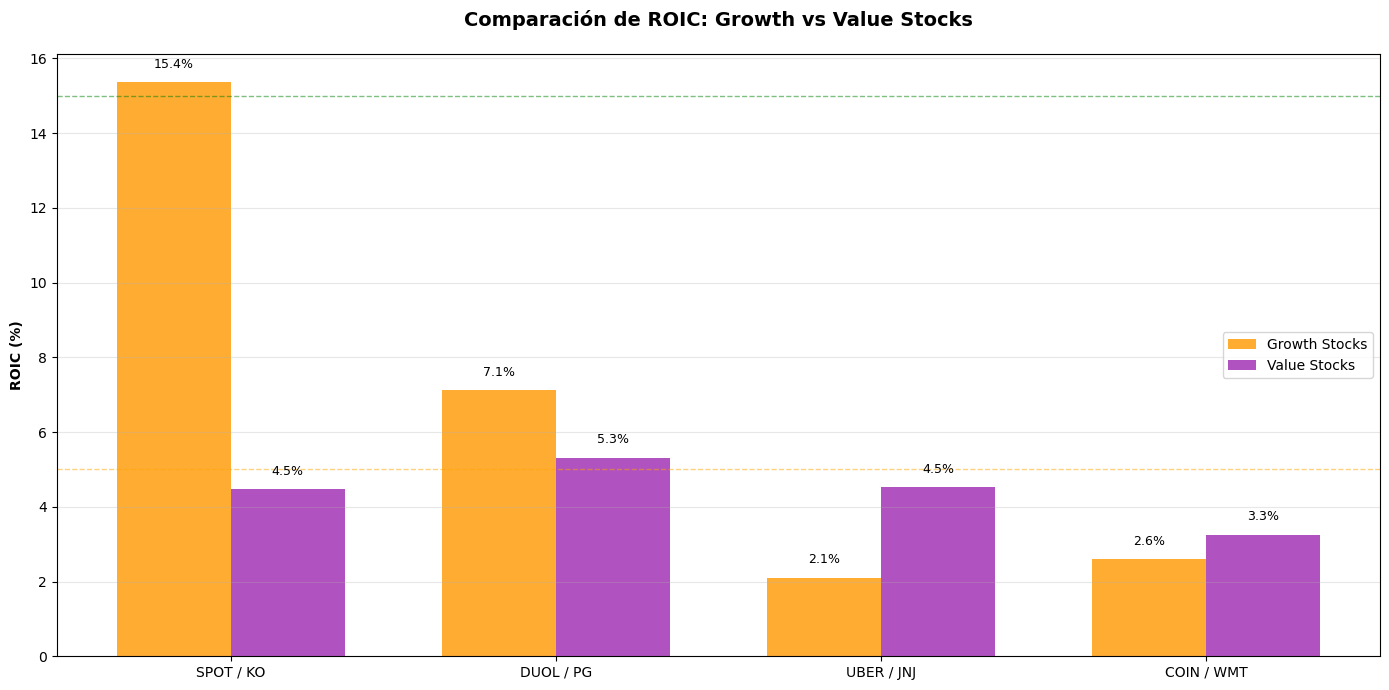

In [55]:
fig, ax = plt.subplots(figsize=(14, 7))

growth_roic = combined_df[combined_df['Category'] == 'Growth']
value_roic = combined_df[combined_df['Category'] == 'Value']

# Generamos las etiquetas combinadas dinámicamente
labels = [f"{g} / {v}" for g, v in zip(growth_roic['Ticker'], value_roic['Ticker'])]

x = np.arange(len(growth_roic))
width = 0.35

# Barras
bars1 = ax.bar(x - width/2, growth_roic['ROIC (%)'], width, 
               label='Growth Stocks', color='#FF9800', alpha=0.8)
bars2 = ax.bar(x + width/2, value_roic['ROIC (%)'].values, width, 
               label='Value Stocks', color='#9C27B0', alpha=0.8)

# Configuración de ejes
ax.set_ylabel('ROIC (%)', fontweight='bold')
ax.set_title('Comparación de ROIC: Growth vs Value Stocks', 
             fontsize=14, fontweight='bold', pad=20)

ax.set_xticks(x)
ax.set_xticklabels(labels) # <--- Aquí aplicamos los pares de tickers
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Líneas de referencia
ax.axhline(y=15, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Excelente (>15%)')
ax.axhline(y=5, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Mínimo aceptable (5%)')

# Etiquetas de datos
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if pd.notna(height):
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.3, # Pequeño offset para que no choque
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 12. Scatter Plot: FCF Yield vs ROIC

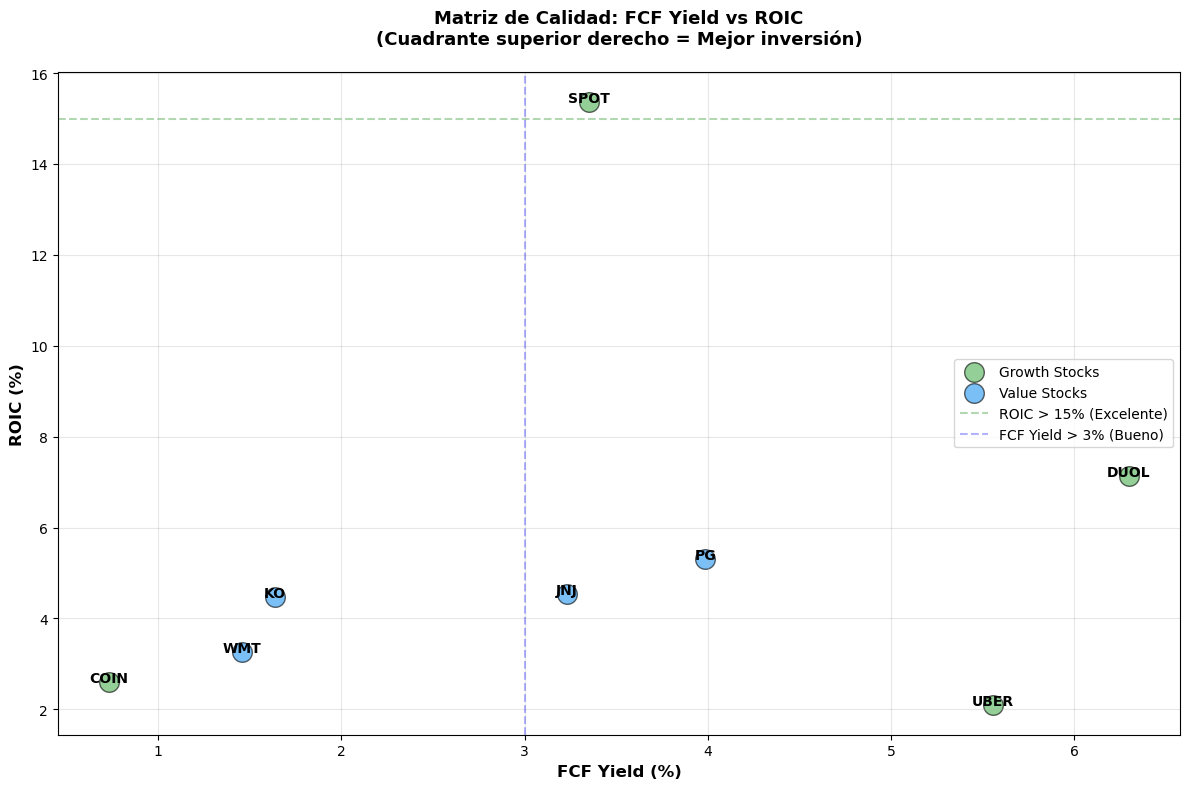

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))

growth_scatter = combined_df[combined_df['Category'] == 'Growth']
value_scatter = combined_df[combined_df['Category'] == 'Value']

ax.scatter(growth_scatter['FCF Yield (%)'], growth_scatter['ROIC (%)'], 
          s=200, alpha=0.6, color='#4CAF50', label='Growth Stocks', edgecolors='black')
ax.scatter(value_scatter['FCF Yield (%)'], value_scatter['ROIC (%)'], 
          s=200, alpha=0.6, color='#2196F3', label='Value Stocks', edgecolors='black')

for _, row in combined_df.iterrows():
    ax.annotate(row['Ticker'], 
               (row['FCF Yield (%)'], row['ROIC (%)']),
               fontsize=10, fontweight='bold', ha='center')

ax.axhline(y=15, color='green', linestyle='--', alpha=0.3, label='ROIC > 15% (Excelente)')
ax.axvline(x=3, color='blue', linestyle='--', alpha=0.3, label='FCF Yield > 3% (Bueno)')

ax.set_xlabel('FCF Yield (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('ROIC (%)', fontsize=12, fontweight='bold')
ax.set_title('Matriz de Calidad: FCF Yield vs ROIC\n(Cuadrante superior derecho = Mejor inversión)', 
            fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Promedios por Categoría

In [57]:
avg_metrics = combined_df.groupby('Category').agg({
    'FCF Yield (%)': 'mean',
    'ROIC (%)': 'mean',
    'FCF Growth YoY (%)': 'mean',
    'P/E Ratio': 'mean'
}).round(2)

print("\n📈 PROMEDIOS POR CATEGORÍA:\n")
print(avg_metrics)
print("\n" + "="*80)


📈 PROMEDIOS POR CATEGORÍA:

          FCF Yield (%)  ROIC (%)  FCF Growth YoY (%)  P/E Ratio
Category                                                        
Growth             3.98       6.8              -40.77      24.65
Value              2.58       4.4               18.30      29.34



## 14. Visualización de Promedios

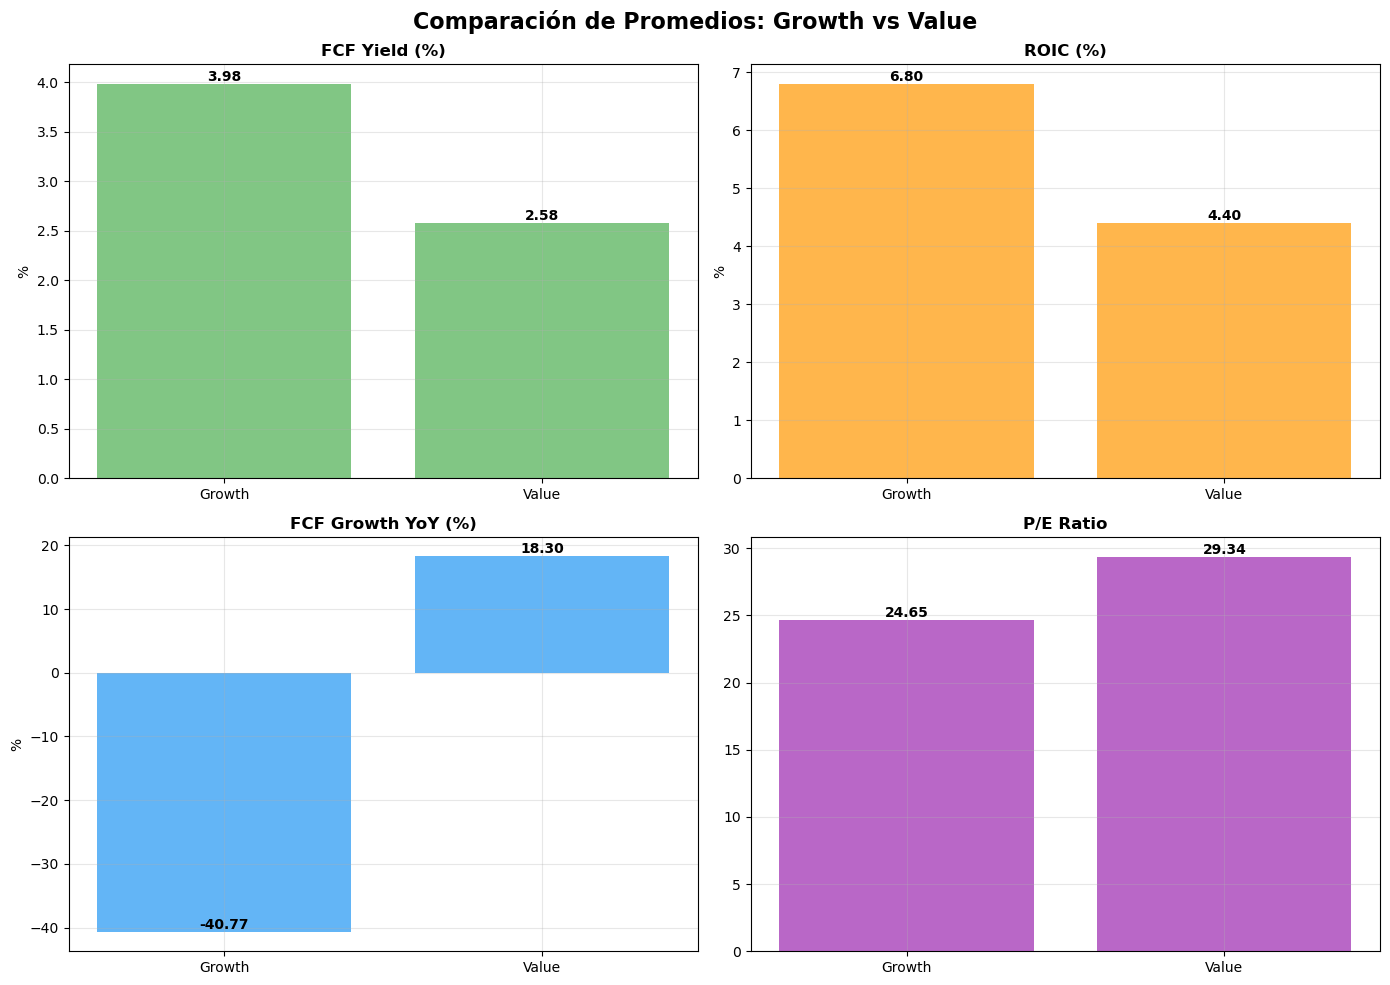

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparación de Promedios: Growth vs Value', fontsize=16, fontweight='bold')

metrics_to_plot = ['FCF Yield (%)', 'ROIC (%)', 'FCF Growth YoY (%)', 'P/E Ratio']
colors = ['#4CAF50', '#FF9800', '#2196F3', '#9C27B0']

for idx, (metric, color) in enumerate(zip(metrics_to_plot, colors)):
    row = idx // 2
    col = idx % 2
    
    data = avg_metrics[metric]
    axes[row, col].bar(data.index, data.values, color=color, alpha=0.7)
    axes[row, col].set_title(metric, fontweight='bold')
    axes[row, col].set_ylabel(metric.split('(')[1].strip(')') if '(' in metric else '')
    axes[row, col].grid(True, alpha=0.3)
    
    for i, v in enumerate(data.values):
        axes[row, col].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 15. Resumen Ejecutivo Completo

In [59]:
print("="*80)
print("📊 RESUMEN EJECUTIVO: GROWTH VS VALUE STOCKS")
print("="*80)

print("\n🏆 TOP 3 por FCF Yield:")
top_fcf = combined_df.nlargest(3, 'FCF Yield (%)')[['Ticker', 'Category', 'FCF Yield (%)']]
for idx, row in top_fcf.iterrows():
    print(f"   {row['Ticker']:6} ({row['Category']:6}) - {row['FCF Yield (%)']:6.2f}%")

print("\n🏆 TOP 3 por ROIC:")
top_roic = combined_df.nlargest(3, 'ROIC (%)')[['Ticker', 'Category', 'ROIC (%)']]
for idx, row in top_roic.iterrows():
    print(f"   {row['Ticker']:6} ({row['Category']:6}) - {row['ROIC (%)']:6.1f}%")

print("\n🏆 TOP 3 por Crecimiento de FCF:")
top_growth = combined_df.nlargest(3, 'FCF Growth YoY (%)')[['Ticker', 'Category', 'FCF Growth YoY (%)']]
for idx, row in top_growth.iterrows():
    print(f"   {row['Ticker']:6} ({row['Category']:6}) - {row['FCF Growth YoY (%)']:+6.1f}%")

print("\n" + "="*80)

📊 RESUMEN EJECUTIVO: GROWTH VS VALUE STOCKS

🏆 TOP 3 por FCF Yield:
   DUOL   (Growth) -   6.30%
   UBER   (Growth) -   5.55%
   PG     (Value ) -   3.99%

🏆 TOP 3 por ROIC:
   SPOT   (Growth) -   15.4%
   DUOL   (Growth) -    7.1%
   PG     (Value ) -    5.3%

🏆 TOP 3 por Crecimiento de FCF:
   JNJ    (Value ) -  +65.3%
   KO     (Value ) -  +45.0%
   PG     (Value ) -  +33.7%



## 16. Valoración Estocástica con Monte Carlo - Setup

In [60]:
from scipy import stats
import seaborn as sns

# Configuración de Monte Carlo
N_SIMULATIONS = 10000
CONFIDENCE_LEVEL = 0.95

print(f"🎲 Configuración Monte Carlo:")
print(f"   Simulaciones: {N_SIMULATIONS:,}")
print(f"   Nivel de confianza: {CONFIDENCE_LEVEL*100}%")

🎲 Configuración Monte Carlo:
   Simulaciones: 10,000
   Nivel de confianza: 95.0%


## 17. Clase de Valoración Estocástica

In [61]:
class StochasticValuation:
    def __init__(self, ticker, current_price, ttm_fcf, market_cap, fcf_growth_yoy):
        self.ticker = ticker
        self.current_price = current_price
        self.ttm_fcf = ttm_fcf  # en millones
        self.market_cap = market_cap * 1000  # convertir a millones
        self.fcf_growth_yoy = fcf_growth_yoy / 100  # convertir a decimal
        
    def simulate_fcf_path(self, n_sims=10000):
        """
        Simula trayectorias de FCF usando distribuciones probabilísticas
        """
        # Parámetros de distribución basados en datos históricos
        # Growth rate: distribución normal con media en el crecimiento observado
        growth_mean = self.fcf_growth_yoy if abs(self.fcf_growth_yoy) < 0.5 else 0.10
        growth_std = 0.15  # volatilidad típica del crecimiento FCF
        
        # Simulación de crecimiento con distribución normal
        growth_rates = np.random.normal(growth_mean, growth_std, n_sims)
        
        # FCF futuro estimado (1 año adelante)
        future_fcf = self.ttm_fcf * (1 + growth_rates)
        
        return future_fcf, growth_rates
    
    def simulate_exit_multiple(self, n_sims=10000):
        """
        Simula múltiplos de salida (FCF Yield) usando distribución log-normal
        """
        # FCF Yield actual
        current_fcf_yield = (self.ttm_fcf / self.market_cap) if self.market_cap > 0 else 0.03
        
        # Parámetros para distribución log-normal del múltiplo
        # Típicamente FCF yields están entre 2% - 8%
        mean_yield = max(0.02, min(0.08, current_fcf_yield))
        
        # Distribución log-normal para múltiplos (siempre positivos)
        mu = np.log(mean_yield)
        sigma = 0.30  # volatilidad del múltiplo
        
        fcf_yields = np.random.lognormal(mu, sigma, n_sims)
        # Limitar valores extremos
        fcf_yields = np.clip(fcf_yields, 0.01, 0.15)
        
        return fcf_yields
    
    def simulate_discount_rate(self, n_sims=10000):
        """
        Simula tasas de descuento (WACC) usando distribución normal
        """
        # WACC típico: 8-12% para la mayoría de empresas
        wacc_mean = 0.10
        wacc_std = 0.02
        
        discount_rates = np.random.normal(wacc_mean, wacc_std, n_sims)
        discount_rates = np.clip(discount_rates, 0.05, 0.20)
        
        return discount_rates
    
    def run_monte_carlo(self, n_sims=10000):
        """
        Ejecuta simulación Monte Carlo completa
        """
        # Simular variables estocásticas
        future_fcf, growth_rates = self.simulate_fcf_path(n_sims)
        exit_yields = self.simulate_exit_multiple(n_sims)
        discount_rates = self.simulate_discount_rate(n_sims)
        
        # Calcular valor terminal: FCF / FCF_Yield
        terminal_values = future_fcf / exit_yields
        
        # Valor presente descontado
        present_values = terminal_values / (1 + discount_rates)
        
        # Valor por acción (asumiendo market cap actual)
        shares_outstanding = self.market_cap / self.current_price if self.current_price > 0 else 1
        price_per_share = present_values / shares_outstanding
        
        return {
            'future_fcf': future_fcf,
            'growth_rates': growth_rates,
            'exit_yields': exit_yields,
            'discount_rates': discount_rates,
            'terminal_values': terminal_values,
            'present_values': present_values,
            'price_per_share': price_per_share
        }
    
    def get_valuation_summary(self, simulation_results):
        """
        Calcula estadísticas de la valoración
        """
        prices = simulation_results['price_per_share']
        
        return {
            'ticker': self.ticker,
            'current_price': self.current_price,
            'mean_price': np.mean(prices),
            'median_price': np.median(prices),
            'std_price': np.std(prices),
            'p10': np.percentile(prices, 10),
            'p25': np.percentile(prices, 25),
            'p75': np.percentile(prices, 75),
            'p90': np.percentile(prices, 90),
            'prob_overvalued': np.mean(prices < self.current_price) * 100,
            'prob_undervalued': np.mean(prices > self.current_price) * 100,
            'upside_potential': ((np.median(prices) / self.current_price) - 1) * 100
        }

print("✅ Clase StochasticValuation definida")

✅ Clase StochasticValuation definida


## 18. Ejecutar Monte Carlo para todas las acciones

In [62]:
print("🎲 Ejecutando simulaciones Monte Carlo...\n")

# Almacenar resultados
mc_results = {}
mc_summaries = []

for _, row in combined_df.iterrows():
    ticker = row['Ticker']
    print(f"Simulando {ticker}...")
    
    valuator = StochasticValuation(
        ticker=ticker,
        current_price=row['Price'],
        ttm_fcf=row['TTM FCF ($M)'],
        market_cap=row['Market Cap ($B)'],
        fcf_growth_yoy=row['FCF Growth YoY (%)']
    )
    
    # Ejecutar Monte Carlo
    sim_results = valuator.run_monte_carlo(N_SIMULATIONS)
    mc_results[ticker] = sim_results
    
    # Obtener resumen
    summary = valuator.get_valuation_summary(sim_results)
    summary['Category'] = row['Category']
    mc_summaries.append(summary)

mc_summary_df = pd.DataFrame(mc_summaries)
print("\n✅ Simulaciones Monte Carlo completadas")
mc_summary_df

🎲 Ejecutando simulaciones Monte Carlo...

Simulando KO...
Simulando PG...
Simulando JNJ...
Simulando WMT...
Simulando SPOT...
Simulando DUOL...
Simulando UBER...
Simulando COIN...

✅ Simulaciones Monte Carlo completadas


,ticker,current_price,mean_price,median_price,std_price,p10,p25,p75,p90,prob_overvalued,prob_undervalued,upside_potential,Category
0,KO,79.03,89.114935,85.019200,28.159645,56.694823,68.873522,105.156830,127.002066,41.17,58.83,7.578388,Value
1,PG,159.17,202.864842,191.758303,67.197361,128.264347,155.191538,239.038659,292.415744,27.76,72.24,20.473898,Value
2,JNJ,239.99,250.562486,236.803791,84.711031,154.539500,190.184572,298.224969,362.624561,51.36,48.64,-1.327643,Value
3,WMT,131.18,100.957643,95.738143,33.865827,62.510201,76.564678,120.047268,146.349916,82.53,17.47,-27.017729,Value
4,SPOT,422.61,367.755982,347.799191,127.987670,224.612545,276.185918,437.112709,535.248068,71.74,28.26,-17.702092,Growth
5,DUOL,119.40,108.320496,102.868374,37.778489,65.733450,81.196175,128.803571,158.008685,67.60,32.40,-13.845583,Growth
6,UBER,74.77,93.216445,88.298095,31.099805,58.177438,71.189437,110.244425,134.455242,30.16,69.84,18.092945,Growth
7,COIN,165.12,63.303704,59.985874,21.202459,39.236959,48.213997,74.776030,91.708659,99.99,0.01,-63.671346,Growth


## 19. Visualización: Distribuciones de Precio - Value Stocks

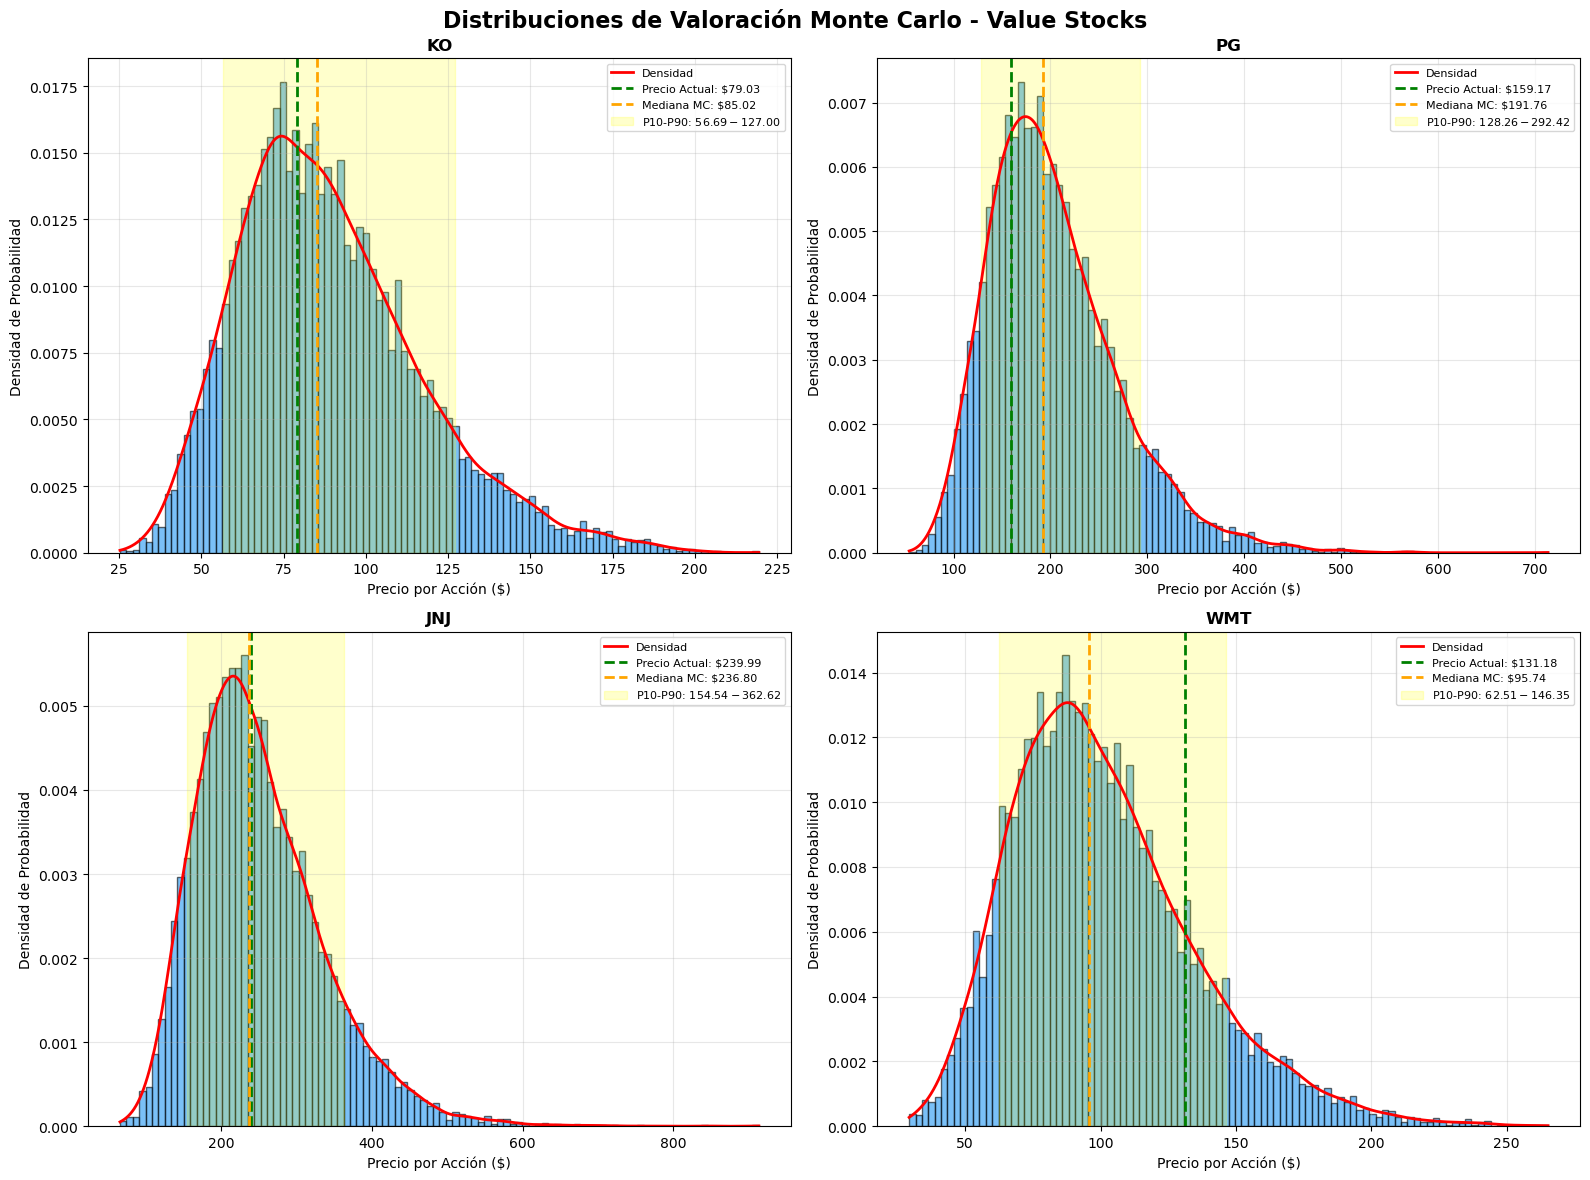

In [63]:
value_tickers_list = value_df['Ticker'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribuciones de Valoración Monte Carlo - Value Stocks', fontsize=16, fontweight='bold')

for idx, ticker in enumerate(value_tickers_list):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    prices = mc_results[ticker]['price_per_share']
    current_price = combined_df[combined_df['Ticker'] == ticker]['Price'].values[0]
    
    # Histograma
    ax.hist(prices, bins=100, alpha=0.6, color='#2196F3', edgecolor='black', density=True)
    
    # Curva de densidad
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(prices)
    x_range = np.linspace(prices.min(), prices.max(), 1000)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='Densidad')
    
    # Precio actual
    ax.axvline(current_price, color='green', linestyle='--', linewidth=2, label=f'Precio Actual: ${current_price:.2f}')
    
    # Mediana
    median_price = np.median(prices)
    ax.axvline(median_price, color='orange', linestyle='--', linewidth=2, label=f'Mediana MC: ${median_price:.2f}')
    
    # Percentiles
    p10 = np.percentile(prices, 10)
    p90 = np.percentile(prices, 90)
    ax.axvspan(p10, p90, alpha=0.2, color='yellow', label=f'P10-P90: ${p10:.2f}-${p90:.2f}')
    
    ax.set_title(f'{ticker}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Precio por Acción ($)')
    ax.set_ylabel('Densidad de Probabilidad')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 20. Visualización: Distribuciones de Precio - Growth Stocks

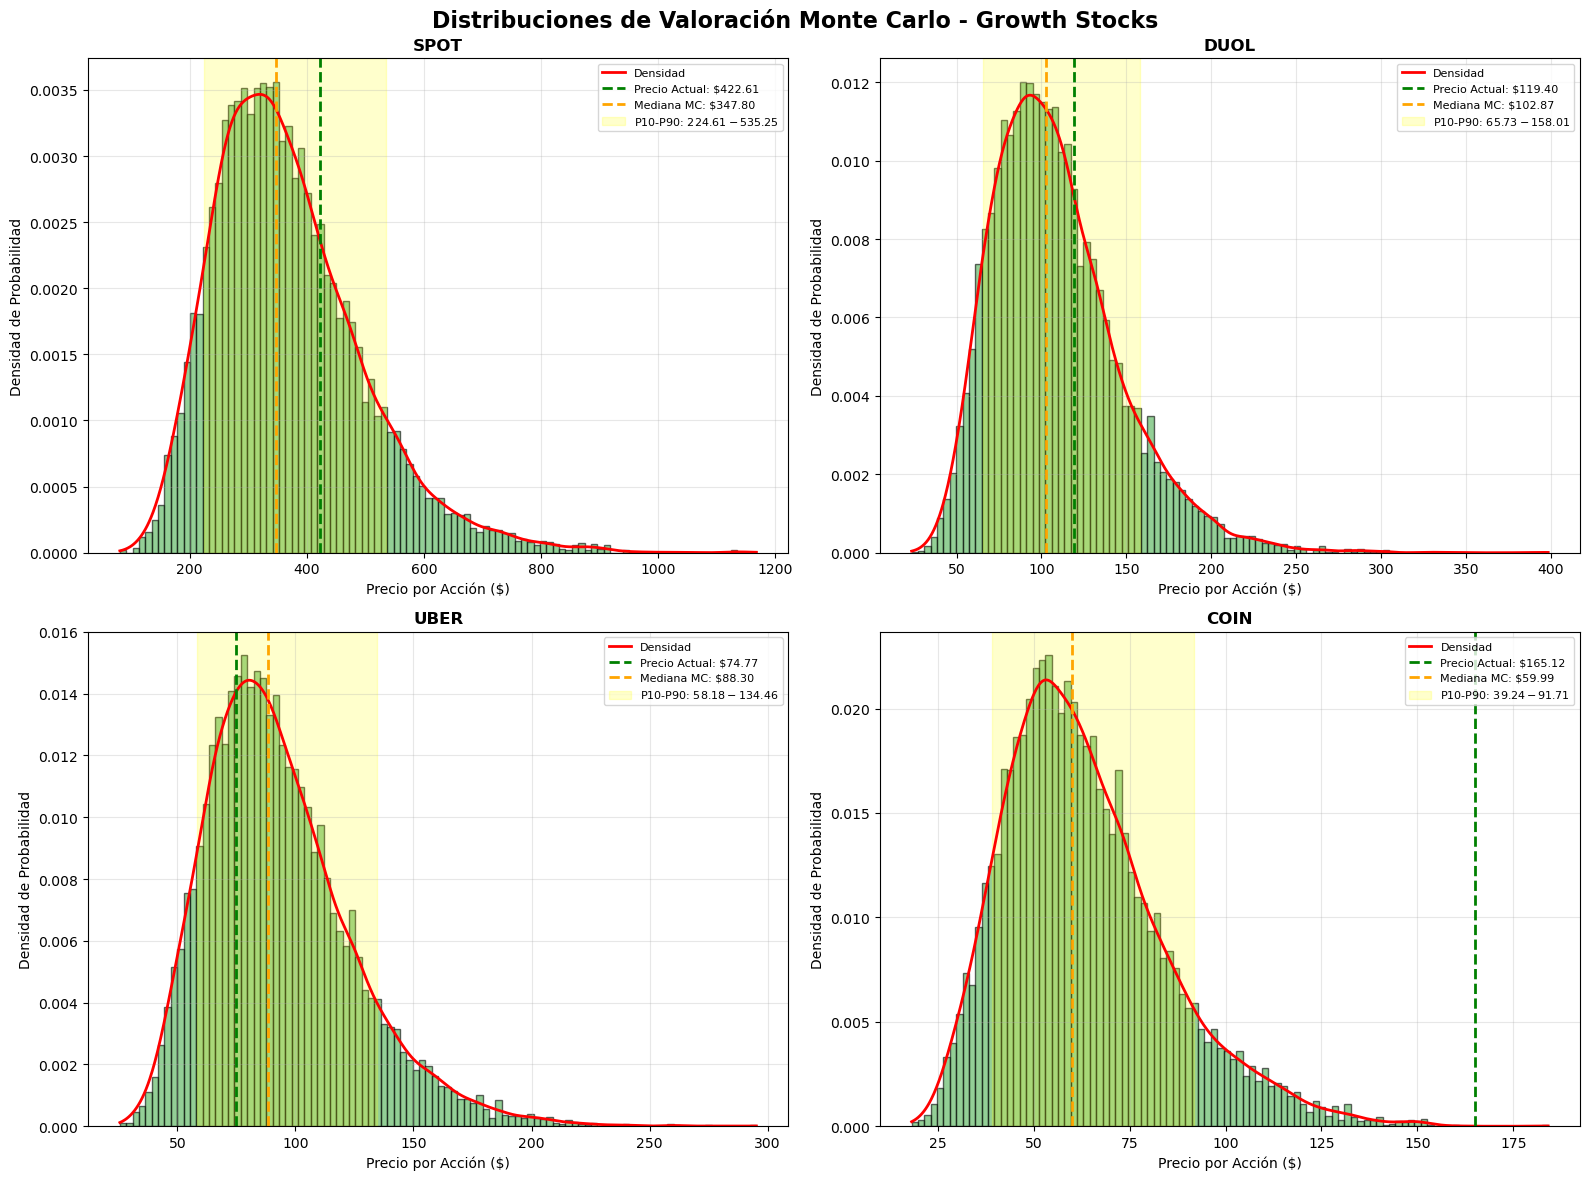

In [64]:
growth_tickers_list = growth_df['Ticker'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribuciones de Valoración Monte Carlo - Growth Stocks', fontsize=16, fontweight='bold')

for idx, ticker in enumerate(growth_tickers_list):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    prices = mc_results[ticker]['price_per_share']
    current_price = combined_df[combined_df['Ticker'] == ticker]['Price'].values[0]
    
    # Histograma
    ax.hist(prices, bins=100, alpha=0.6, color='#4CAF50', edgecolor='black', density=True)
    
    # Curva de densidad
    from scipy.stats import gaussian_kde
    kde = gaussian_kde(prices)
    x_range = np.linspace(prices.min(), prices.max(), 1000)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='Densidad')
    
    # Precio actual
    ax.axvline(current_price, color='green', linestyle='--', linewidth=2, label=f'Precio Actual: ${current_price:.2f}')
    
    # Mediana
    median_price = np.median(prices)
    ax.axvline(median_price, color='orange', linestyle='--', linewidth=2, label=f'Mediana MC: ${median_price:.2f}')
    
    # Percentiles
    p10 = np.percentile(prices, 10)
    p90 = np.percentile(prices, 90)
    ax.axvspan(p10, p90, alpha=0.2, color='yellow', label=f'P10-P90: ${p10:.2f}-${p90:.2f}')
    
    ax.set_title(f'{ticker}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Precio por Acción ($)')
    ax.set_ylabel('Densidad de Probabilidad')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 21. Comparación: Valoración Estática vs Estocástica

In [65]:
comparison_df = mc_summary_df[['ticker', 'Category', 'current_price', 'median_price', 
                                'mean_price', 'p10', 'p90', 'upside_potential', 
                                'prob_undervalued']].copy()

comparison_df.columns = ['Ticker', 'Category', 'Precio Actual', 'Precio Mediano MC', 
                         'Precio Promedio MC', 'P10', 'P90', 'Upside (%)', 
                         'Prob. Subvaluada (%)']

print("📊 COMPARACIÓN: VALORACIÓN ESTÁTICA vs ESTOCÁSTICA\n")
comparison_df.sort_values('Upside (%)', ascending=False)

📊 COMPARACIÓN: VALORACIÓN ESTÁTICA vs ESTOCÁSTICA



,Ticker,Category,Precio Actual,Precio Mediano MC,Precio Promedio MC,P10,P90,Upside (%),Prob. Subvaluada (%)
1,PG,Value,159.17,191.758303,202.864842,128.264347,292.415744,20.473898,72.24
6,UBER,Growth,74.77,88.298095,93.216445,58.177438,134.455242,18.092945,69.84
0,KO,Value,79.03,85.019200,89.114935,56.694823,127.002066,7.578388,58.83
2,JNJ,Value,239.99,236.803791,250.562486,154.539500,362.624561,-1.327643,48.64
5,DUOL,Growth,119.40,102.868374,108.320496,65.733450,158.008685,-13.845583,32.40
4,SPOT,Growth,422.61,347.799191,367.755982,224.612545,535.248068,-17.702092,28.26
3,WMT,Value,131.18,95.738143,100.957643,62.510201,146.349916,-27.017729,17.47
7,COIN,Growth,165.12,59.985874,63.303704,39.236959,91.708659,-63.671346,0.01


## 22. Visualización: Upside Potential con Intervalos de Confianza

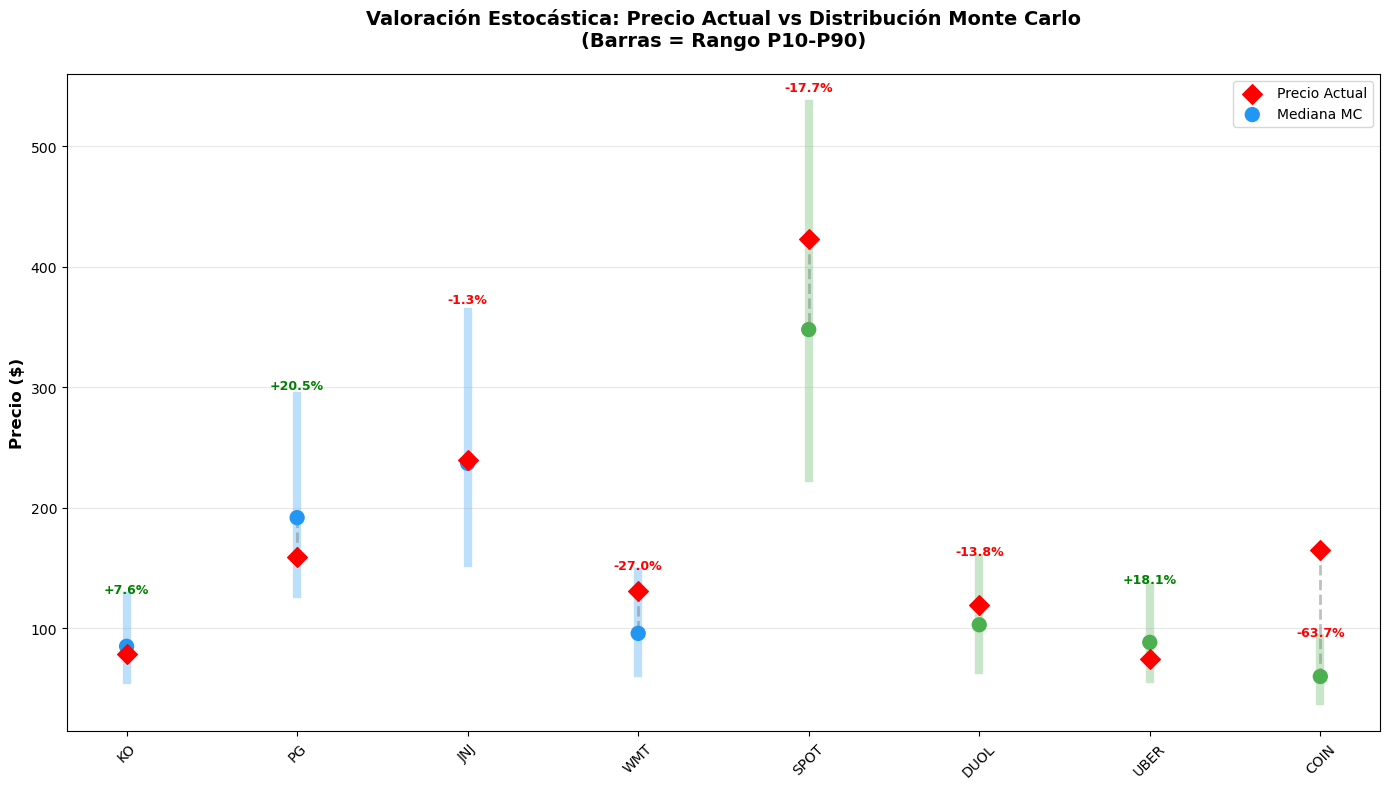

In [66]:
fig, ax = plt.subplots(figsize=(14, 8))

# Preparar datos
tickers = mc_summary_df['ticker'].values
current_prices = mc_summary_df['current_price'].values
median_prices = mc_summary_df['median_price'].values
p10 = mc_summary_df['p10'].values
p90 = mc_summary_df['p90'].values
categories = mc_summary_df['Category'].values

x = np.arange(len(tickers))

# Colores por categoría
colors = ['#4CAF50' if cat == 'Growth' else '#2196F3' for cat in categories]

# Precio actual
ax.scatter(x, current_prices, s=100, color='red', marker='D', label='Precio Actual', zorder=5)

# Mediana MC
ax.scatter(x, median_prices, s=100, color=colors, marker='o', label='Mediana MC', zorder=4)

# Intervalos de confianza (P10-P90)
for i in range(len(tickers)):
    ax.plot([i, i], [p10[i], p90[i]], color=colors[i], linewidth=6, alpha=0.3, zorder=1)
    ax.plot([i, i], [current_prices[i], median_prices[i]], color='gray', 
           linewidth=2, linestyle='--', alpha=0.5, zorder=2)

ax.set_xticks(x)
ax.set_xticklabels(tickers, rotation=45)
ax.set_ylabel('Precio ($)', fontweight='bold', fontsize=12)
ax.set_title('Valoración Estocástica: Precio Actual vs Distribución Monte Carlo\n(Barras = Rango P10-P90)', 
            fontsize=14, fontweight='bold', pad=20)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Añadir etiquetas de upside
for i, (ticker, upside) in enumerate(zip(tickers, mc_summary_df['upside_potential'].values)):
    ax.text(i, max(p90[i], median_prices[i]) * 1.02, f'{upside:+.1f}%', 
           ha='center', fontsize=9, fontweight='bold', 
           color='green' if upside > 0 else 'red')

plt.tight_layout()
plt.show()

## 23. Análisis de Riesgo: Probabilidad de Downside

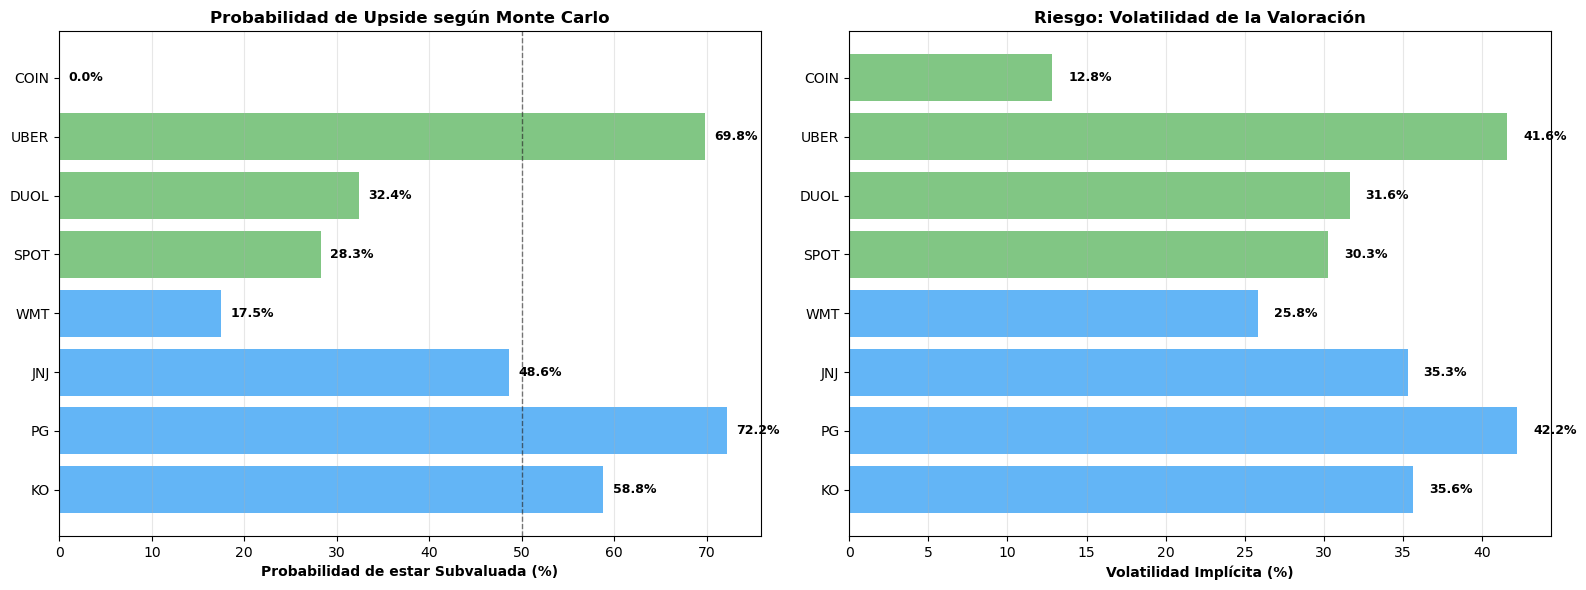

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Probabilidad de estar subvaluada
ax1 = axes[0]
categories_list = mc_summary_df['Category'].values
colors = ['#4CAF50' if cat == 'Growth' else '#2196F3' for cat in categories_list]

bars1 = ax1.barh(mc_summary_df['ticker'], mc_summary_df['prob_undervalued'], color=colors, alpha=0.7)
ax1.axvline(50, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_xlabel('Probabilidad de estar Subvaluada (%)', fontweight='bold')
ax1.set_title('Probabilidad de Upside según Monte Carlo', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')

for i, (bar, prob) in enumerate(zip(bars1, mc_summary_df['prob_undervalued'].values)):
    ax1.text(prob + 1, bar.get_y() + bar.get_height()/2, f'{prob:.1f}%', 
            va='center', fontsize=9, fontweight='bold')

# Gráfico 2: Volatilidad implícita (desviación estándar)
ax2 = axes[1]
volatility = (mc_summary_df['std_price'] / mc_summary_df['current_price'] * 100).values

bars2 = ax2.barh(mc_summary_df['ticker'], volatility, color=colors, alpha=0.7)
ax2.set_xlabel('Volatilidad Implícita (%)', fontweight='bold')
ax2.set_title('Riesgo: Volatilidad de la Valoración', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='x')

for i, (bar, vol) in enumerate(zip(bars2, volatility)):
    ax2.text(vol + 1, bar.get_y() + bar.get_height()/2, f'{vol:.1f}%', 
            va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 24. Matriz de Riesgo-Retorno Estocástica

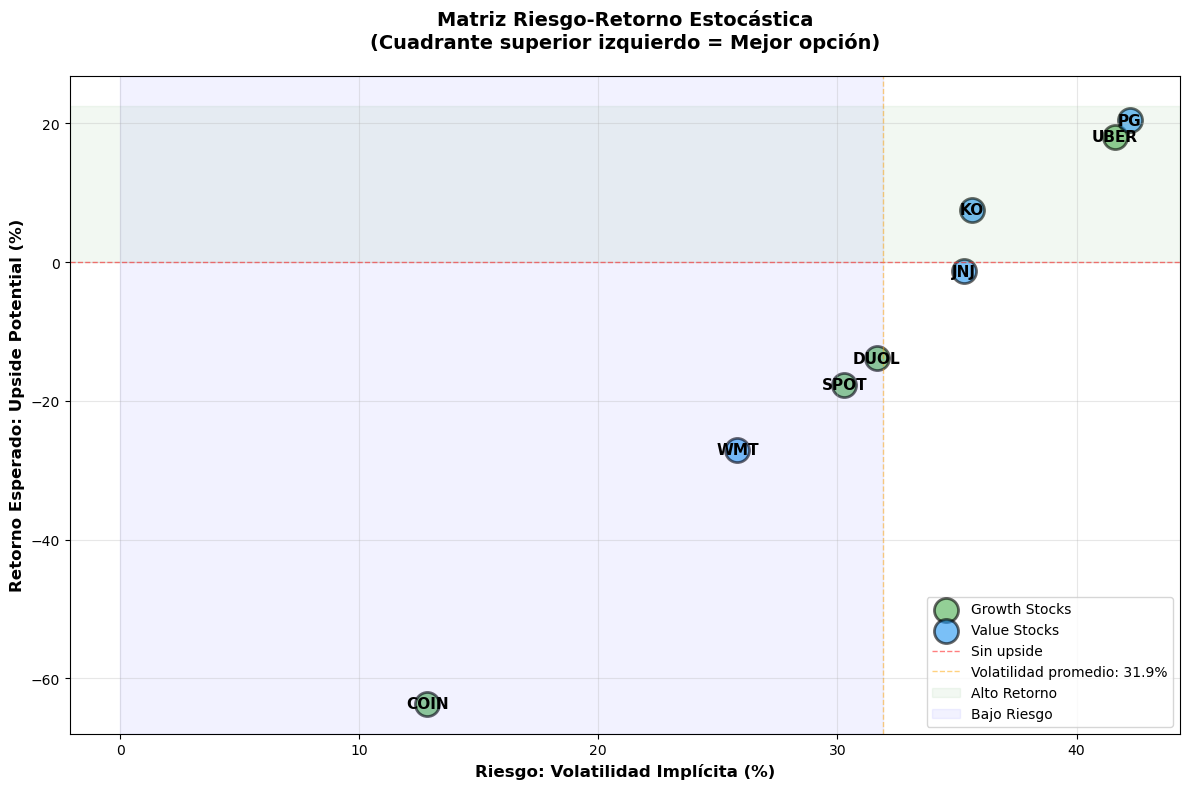

In [68]:
fig, ax = plt.subplots(figsize=(12, 8))

# Calcular métricas
upside = mc_summary_df['upside_potential'].values
volatility = (mc_summary_df['std_price'] / mc_summary_df['current_price'] * 100).values

growth_mask = mc_summary_df['Category'] == 'Growth'
value_mask = mc_summary_df['Category'] == 'Value'

# Scatter plots
ax.scatter(volatility[growth_mask], upside[growth_mask], 
          s=300, alpha=0.6, color='#4CAF50', label='Growth Stocks', edgecolors='black', linewidth=2)
ax.scatter(volatility[value_mask], upside[value_mask], 
          s=300, alpha=0.6, color='#2196F3', label='Value Stocks', edgecolors='black', linewidth=2)

# Anotaciones
for i, ticker in enumerate(mc_summary_df['ticker']):
    ax.annotate(ticker, (volatility[i], upside[i]), 
               fontsize=11, fontweight='bold', ha='center', va='center')

# Líneas de referencia
ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Sin upside')
ax.axvline(volatility.mean(), color='orange', linestyle='--', linewidth=1, alpha=0.5, 
          label=f'Volatilidad promedio: {volatility.mean():.1f}%')

# Cuadrantes
ax.axhspan(0, max(upside)*1.1, alpha=0.05, color='green', label='Alto Retorno')
ax.axvspan(0, volatility.mean(), alpha=0.05, color='blue', label='Bajo Riesgo')

ax.set_xlabel('Riesgo: Volatilidad Implícita (%)', fontweight='bold', fontsize=12)
ax.set_ylabel('Retorno Esperado: Upside Potential (%)', fontweight='bold', fontsize=12)
ax.set_title('Matriz Riesgo-Retorno Estocástica\n(Cuadrante superior izquierdo = Mejor opción)', 
            fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 25. Resumen Ejecutivo: Valoración Estocástica

In [69]:
print("="*80)
print("🎲 RESUMEN EJECUTIVO: VALORACIÓN ESTOCÁSTICA (MONTE CARLO)")
print("="*80)

print(f"\nSimulaciones realizadas: {N_SIMULATIONS:,} por acción")
print(f"Variables estocásticas: Tasa de crecimiento FCF, FCF Yield de salida, WACC\n")

print("🏆 MAYOR UPSIDE POTENTIAL (según mediana Monte Carlo):")
top_upside = mc_summary_df.nlargest(3, 'upside_potential')[['ticker', 'Category', 'current_price', 'median_price', 'upside_potential']]
for _, row in top_upside.iterrows():
    print(f"   {row['ticker']:6} ({row['Category']:6}) - Actual: ${row['current_price']:6.2f} | MC: ${row['median_price']:6.2f} | Upside: {row['upside_potential']:+6.1f}%")

print("\n🎯 MAYOR PROBABILIDAD DE ESTAR SUBVALUADA:")
top_prob = mc_summary_df.nlargest(3, 'prob_undervalued')[['ticker', 'Category', 'prob_undervalued']]
for _, row in top_prob.iterrows():
    print(f"   {row['ticker']:6} ({row['Category']:6}) - Probabilidad: {row['prob_undervalued']:5.1f}%")

print("\n⚠️ MAYOR RIESGO (volatilidad implícita):")
mc_summary_df['volatility'] = (mc_summary_df['std_price'] / mc_summary_df['current_price'] * 100)
top_risk = mc_summary_df.nlargest(3, 'volatility')[['ticker', 'Category', 'volatility']]
for _, row in top_risk.iterrows():
    print(f"   {row['ticker']:6} ({row['Category']:6}) - Volatilidad: {row['volatility']:5.1f}%")

print("\n📊 COMPARACIÓN PROMEDIO POR CATEGORÍA:")
category_stats = mc_summary_df.groupby('Category').agg({
    'upside_potential': 'mean',
    'prob_undervalued': 'mean',
    'volatility': 'mean'
}).round(2)
category_stats.columns = ['Upside Promedio (%)', 'Prob. Subvaluada (%)', 'Volatilidad (%)']
print(category_stats)

print("\n" + "="*80)
print("💡 INTERPRETACIÓN:")
print("   - Upside > 0: El mercado podría estar subvaluando la acción")
print("   - Probabilidad > 50%: Más probable estar subvaluada que sobrevaluada")
print("   - Volatilidad alta: Mayor incertidumbre en la valoración")
print("="*80)

🎲 RESUMEN EJECUTIVO: VALORACIÓN ESTOCÁSTICA (MONTE CARLO)

Simulaciones realizadas: 10,000 por acción
Variables estocásticas: Tasa de crecimiento FCF, FCF Yield de salida, WACC

🏆 MAYOR UPSIDE POTENTIAL (según mediana Monte Carlo):
   PG     (Value ) - Actual: $159.17 | MC: $191.76 | Upside:  +20.5%
   UBER   (Growth) - Actual: $ 74.77 | MC: $ 88.30 | Upside:  +18.1%
   KO     (Value ) - Actual: $ 79.03 | MC: $ 85.02 | Upside:   +7.6%

🎯 MAYOR PROBABILIDAD DE ESTAR SUBVALUADA:
   PG     (Value ) - Probabilidad:  72.2%
   UBER   (Growth) - Probabilidad:  69.8%
   KO     (Value ) - Probabilidad:  58.8%

⚠️ MAYOR RIESGO (volatilidad implícita):
   PG     (Value ) - Volatilidad:  42.2%
   UBER   (Growth) - Volatilidad:  41.6%
   KO     (Value ) - Volatilidad:  35.6%

📊 COMPARACIÓN PROMEDIO POR CATEGORÍA:
          Upside Promedio (%)  Prob. Subvaluada (%)  Volatilidad (%)
Category                                                            
Growth                 -19.28                 32.6

## 26. Inicializar Base de Datos SQLite

In [70]:
conn = sqlite3.connect('stock_analysis.db')
cursor = conn.cursor()

# Crear tabla de categorías
cursor.execute('''
CREATE TABLE IF NOT EXISTS stock_categories (
    ticker TEXT PRIMARY KEY,
    category TEXT NOT NULL,
    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
''')

# Crear tabla de métricas
cursor.execute('''
CREATE TABLE IF NOT EXISTS stock_metrics (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    ticker TEXT NOT NULL,
    category TEXT NOT NULL,
    price REAL,
    market_cap REAL,
    pe_ratio REAL,
    ttm_fcf REAL,
    fcf_yield REAL,
    roic REAL,
    fcf_growth REAL,
    analysis_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
''')

# Crear tabla de promedios por categoría
cursor.execute('''
CREATE TABLE IF NOT EXISTS category_averages (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    category TEXT NOT NULL,
    avg_fcf_yield REAL,
    avg_roic REAL,
    avg_fcf_growth REAL,
    avg_pe_ratio REAL,
    sample_size INTEGER,
    analysis_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
''')

# Crear tabla de rankings
cursor.execute('''
CREATE TABLE IF NOT EXISTS rankings (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    ticker TEXT NOT NULL,
    category TEXT NOT NULL,
    metric_name TEXT NOT NULL,
    metric_value REAL,
    rank INTEGER,
    analysis_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
''')

# Crear tabla de valoraciones Monte Carlo
cursor.execute('''
CREATE TABLE IF NOT EXISTS monte_carlo_valuations (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    ticker TEXT NOT NULL,
    category TEXT NOT NULL,
    current_price REAL,
    median_price REAL,
    mean_price REAL,
    std_price REAL,
    p10 REAL,
    p90 REAL,
    upside_potential REAL,
    prob_undervalued REAL,
    volatility REAL,
    n_simulations INTEGER,
    analysis_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
''')

conn.commit()
print("✅ Base de datos SQLite inicializada")

✅ Base de datos SQLite inicializada


## 27. Guardar Categorías de Stocks

In [71]:
print("💾 Guardando categorías de stocks...")

for _, row in combined_df.iterrows():
    cursor.execute('''
    INSERT OR REPLACE INTO stock_categories (ticker, category, updated_at)
    VALUES (?, ?, CURRENT_TIMESTAMP)
    ''', (row['Ticker'], row['Category']))

conn.commit()
print("✅ Categorías guardadas exitosamente")

💾 Guardando categorías de stocks...
✅ Categorías guardadas exitosamente


## 28. Guardar Métricas Comparativas

In [72]:
print("💾 Guardando métricas comparativas...")

for _, row in combined_df.iterrows():
    cursor.execute('''
    INSERT INTO stock_metrics 
    (ticker, category, price, market_cap, pe_ratio, ttm_fcf, fcf_yield, roic, fcf_growth)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        row['Ticker'],
        row['Category'],
        row['Price'],
        row['Market Cap ($B)'],
        row['P/E Ratio'],
        row['TTM FCF ($M)'],
        row['FCF Yield (%)'],
        row['ROIC (%)'],
        row['FCF Growth YoY (%)']
    ))

conn.commit()
print("✅ Métricas guardadas exitosamente")

💾 Guardando métricas comparativas...
✅ Métricas guardadas exitosamente


## 29. Guardar Promedios por Categoría

In [73]:
print("💾 Guardando promedios por categoría...")

for category in ['Growth', 'Value']:
    sample_size = len(combined_df[combined_df['Category'] == category])
    
    cursor.execute('''
    INSERT INTO category_averages 
    (category, avg_fcf_yield, avg_roic, avg_fcf_growth, avg_pe_ratio, sample_size)
    VALUES (?, ?, ?, ?, ?, ?)
    ''', (
        category,
        avg_metrics.loc[category, 'FCF Yield (%)'],
        avg_metrics.loc[category, 'ROIC (%)'],
        avg_metrics.loc[category, 'FCF Growth YoY (%)'],
        avg_metrics.loc[category, 'P/E Ratio'],
        sample_size
    ))

conn.commit()
print("✅ Promedios guardados exitosamente")

💾 Guardando promedios por categoría...
✅ Promedios guardados exitosamente


## 30. Guardar Rankings

In [74]:
print("💾 Guardando rankings...")

# Top por FCF Yield
top_fcf = combined_df.nlargest(3, 'FCF Yield (%)')
for rank, (_, row) in enumerate(top_fcf.iterrows(), 1):
    cursor.execute('''
    INSERT INTO rankings (ticker, category, metric_name, metric_value, rank)
    VALUES (?, ?, ?, ?, ?)
    ''', (row['Ticker'], row['Category'], 'FCF Yield (%)', row['FCF Yield (%)'], rank))

# Top por ROIC
top_roic = combined_df.nlargest(3, 'ROIC (%)')
for rank, (_, row) in enumerate(top_roic.iterrows(), 1):
    cursor.execute('''
    INSERT INTO rankings (ticker, category, metric_name, metric_value, rank)
    VALUES (?, ?, ?, ?, ?)
    ''', (row['Ticker'], row['Category'], 'ROIC (%)', row['ROIC (%)'], rank))

# Top por FCF Growth
top_growth = combined_df.nlargest(3, 'FCF Growth YoY (%)')
for rank, (_, row) in enumerate(top_growth.iterrows(), 1):
    cursor.execute('''
    INSERT INTO rankings (ticker, category, metric_name, metric_value, rank)
    VALUES (?, ?, ?, ?, ?)
    ''', (row['Ticker'], row['Category'], 'FCF Growth YoY (%)', row['FCF Growth YoY (%)'], rank))

conn.commit()
print("✅ Rankings guardados exitosamente")

💾 Guardando rankings...
✅ Rankings guardados exitosamente


## 31. Guardar Valoraciones Monte Carlo

In [75]:
print("💾 Guardando valoraciones Monte Carlo...")

for _, row in mc_summary_df.iterrows():
    cursor.execute('''
    INSERT INTO monte_carlo_valuations 
    (ticker, category, current_price, median_price, mean_price, std_price, 
     p10, p90, upside_potential, prob_undervalued, volatility, n_simulations)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        row['ticker'],
        row['Category'],
        row['current_price'],
        row['median_price'],
        row['mean_price'],
        row['std_price'],
        row['p10'],
        row['p90'],
        row['upside_potential'],
        row['prob_undervalued'],
        row['volatility'],
        N_SIMULATIONS
    ))

conn.commit()
print("✅ Valoraciones Monte Carlo guardadas exitosamente")

💾 Guardando valoraciones Monte Carlo...
✅ Valoraciones Monte Carlo guardadas exitosamente


## 32. Consultar Última Comparación Guardada

In [76]:
print("📊 Consultando última comparación guardada...\n")

query = '''
SELECT ticker, category, fcf_yield, roic, analysis_date
FROM stock_metrics
WHERE analysis_date = (SELECT MAX(analysis_date) FROM stock_metrics)
ORDER BY fcf_yield DESC
'''

latest_df = pd.read_sql_query(query, conn)
print("Última comparación:")
latest_df

📊 Consultando última comparación guardada...

Última comparación:


,ticker,category,fcf_yield,roic,analysis_date
0,DUOL,Growth,6.297547,7.130069,2026-02-07 12:32:44
1,UBER,Growth,5.554532,2.103970,2026-02-07 12:32:44
2,PG,Value,3.985665,5.314736,2026-02-07 12:32:44
3,SPOT,Growth,3.350079,15.356713,2026-02-07 12:32:44
4,JNJ,Value,3.230505,4.531217,2026-02-07 12:32:44
5,KO,Value,1.637663,4.475782,2026-02-07 12:32:44
6,WMT,Value,1.459347,3.258474,2026-02-07 12:32:44
7,COIN,Growth,0.731822,2.605610,2026-02-07 12:32:44


## 33. Consultar Tendencias Históricas

In [77]:
print("📈 Consultando tendencias históricas...\n")

# Tendencia de Growth stocks
query_growth = '''
SELECT analysis_date, avg_fcf_yield, avg_roic, avg_fcf_growth
FROM category_averages
WHERE category = 'Growth'
  AND analysis_date >= date('now', '-180 days')
ORDER BY analysis_date DESC
'''

growth_trend = pd.read_sql_query(query_growth, conn)
if not growth_trend.empty:
    print("Tendencia Growth stocks (últimos 6 meses):")
    print(growth_trend.head())
else:
    print("No hay datos históricos suficientes para Growth stocks")

print("\n" + "="*80 + "\n")

# Tendencia de Value stocks
query_value = '''
SELECT analysis_date, avg_fcf_yield, avg_roic, avg_fcf_growth
FROM category_averages
WHERE category = 'Value'
  AND analysis_date >= date('now', '-180 days')
ORDER BY analysis_date DESC
'''

value_trend = pd.read_sql_query(query_value, conn)
if not value_trend.empty:
    print("Tendencia Value stocks (últimos 6 meses):")
    print(value_trend.head())
else:
    print("No hay datos históricos suficientes para Value stocks")

📈 Consultando tendencias históricas...

Tendencia Growth stocks (últimos 6 meses):
         analysis_date  avg_fcf_yield  avg_roic  avg_fcf_growth
0  2026-02-07 12:32:44           3.98       6.8          -40.77
1  2026-02-06 20:20:45           4.01       6.8          -40.77
2  2026-02-06 19:37:26           4.03       6.8          -40.77


Tendencia Value stocks (últimos 6 meses):
         analysis_date  avg_fcf_yield  avg_roic  avg_fcf_growth
0  2026-02-07 12:32:44           2.58       4.4            18.3
1  2026-02-06 20:20:45           2.58       4.4            18.3
2  2026-02-06 19:37:26           2.58       4.4            18.3


## 34. Consultar Top Rankings Históricos

In [78]:
print("🏆 Consultando rankings históricos...\n")

query_rankings = '''
SELECT ticker, category, metric_name, metric_value, rank, analysis_date
FROM rankings
WHERE analysis_date = (SELECT MAX(analysis_date) FROM rankings)
ORDER BY metric_name, rank
'''

rankings_df = pd.read_sql_query(query_rankings, conn)
if not rankings_df.empty:
    print("Rankings actuales:")
    print(rankings_df)
else:
    print("No hay rankings guardados")

🏆 Consultando rankings históricos...

Rankings actuales:
  ticker category         metric_name  metric_value  rank        analysis_date
0    JNJ    Value  FCF Growth YoY (%)     65.274907     1  2026-02-07 12:32:44
1     KO    Value  FCF Growth YoY (%)     44.980940     2  2026-02-07 12:32:44
2     PG    Value  FCF Growth YoY (%)     33.696416     3  2026-02-07 12:32:44
3   DUOL   Growth       FCF Yield (%)      6.297547     1  2026-02-07 12:32:44
4   UBER   Growth       FCF Yield (%)      5.554532     2  2026-02-07 12:32:44
5     PG    Value       FCF Yield (%)      3.985665     3  2026-02-07 12:32:44
6   SPOT   Growth            ROIC (%)     15.356713     1  2026-02-07 12:32:44
7   DUOL   Growth            ROIC (%)      7.130069     2  2026-02-07 12:32:44
8     PG    Value            ROIC (%)      5.314736     3  2026-02-07 12:32:44


## 35. Consultar Valoraciones Monte Carlo Guardadas

In [79]:
print("🎲 Consultando valoraciones Monte Carlo guardadas...\n")

query_mc = '''
SELECT ticker, category, current_price, median_price, upside_potential, 
       prob_undervalued, volatility, analysis_date
FROM monte_carlo_valuations
WHERE analysis_date = (SELECT MAX(analysis_date) FROM monte_carlo_valuations)
ORDER BY upside_potential DESC
'''

mc_saved_df = pd.read_sql_query(query_mc, conn)
if not mc_saved_df.empty:
    print("Valoraciones Monte Carlo actuales:")
    print(mc_saved_df)
else:
    print("No hay valoraciones Monte Carlo guardadas")

🎲 Consultando valoraciones Monte Carlo guardadas...

Valoraciones Monte Carlo actuales:
  ticker category  current_price  median_price  upside_potential  \
0     PG    Value         159.17    191.758303         20.473898   
1   UBER   Growth          74.77     88.298095         18.092945   
2     KO    Value          79.03     85.019200          7.578388   
3    JNJ    Value         239.99    236.803791         -1.327643   
4   DUOL   Growth         119.40    102.868374        -13.845583   
5   SPOT   Growth         422.61    347.799191        -17.702092   
6    WMT    Value         131.18     95.738143        -27.017729   
7   COIN   Growth         165.12     59.985874        -63.671346   

   prob_undervalued  volatility        analysis_date  
0             72.24   42.217353  2026-02-07 12:32:44  
1             69.84   41.593961  2026-02-07 12:32:44  
2             58.83   35.631589  2026-02-07 12:32:44  
3             48.64   35.297734  2026-02-07 12:32:44  
4             32.40   31

## 36. Estadísticas de la Base de Datos

In [80]:
print("="*80)
print("📊 ESTADÍSTICAS DE BASE DE DATOS")
print("="*80)

# Contar registros por tabla
cursor.execute("SELECT COUNT(*) FROM stock_categories")
cat_count = cursor.fetchone()[0]
print(f"\nCategorías registradas: {cat_count}")

cursor.execute("SELECT COUNT(*) FROM stock_metrics")
metrics_count = cursor.fetchone()[0]
print(f"Métricas históricas: {metrics_count}")

cursor.execute("SELECT COUNT(*) FROM category_averages")
avg_count = cursor.fetchone()[0]
print(f"Promedios registrados: {avg_count}")

cursor.execute("SELECT COUNT(*) FROM rankings")
rank_count = cursor.fetchone()[0]
print(f"Rankings guardados: {rank_count}")

cursor.execute("SELECT COUNT(*) FROM monte_carlo_valuations")
mc_count = cursor.fetchone()[0]
print(f"Valoraciones Monte Carlo: {mc_count}")

# Fechas de análisis
cursor.execute("SELECT MIN(analysis_date), MAX(analysis_date) FROM stock_metrics")
min_date, max_date = cursor.fetchone()
if min_date and max_date:
    print(f"\nPrimer análisis: {min_date}")
    print(f"Último análisis: {max_date}")

print("\n" + "="*80)

📊 ESTADÍSTICAS DE BASE DE DATOS

Categorías registradas: 8
Métricas históricas: 24
Promedios registrados: 6
Rankings guardados: 27
Valoraciones Monte Carlo: 16

Primer análisis: 2026-02-06 19:37:26
Último análisis: 2026-02-07 12:32:44



## 37. Cerrar Conexión a Base de Datos

In [81]:
conn.close()
print("✅ Conexión a base de datos cerrada")
print("\n💾 Todos los datos han sido guardados en: stock_analysis.db")
print("\n📊 Análisis completo finalizado exitosamente!")

✅ Conexión a base de datos cerrada

💾 Todos los datos han sido guardados en: stock_analysis.db

📊 Análisis completo finalizado exitosamente!
